<center>
<h4>Diplomatura Datos 2021 - FaMAF - UNC</h4>
<h1>Aplicando Machine Learning para predicción de demanda</h1>
<h3>Análisis y Visualización</h3>
</center>
</left>
<h4>Dario Yvanoff</h4>
</left>

[Proyecto para Mentoría](https://sites.google.com/view/mentorias2021-diplodatos/aplicando-machine-learning-para-predicci%C3%B3n-de-demanda?authuser=0)



# Lectura de los datos

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from scipy import stats
from math import sqrt
from scipy.stats import t
import missingno as msno

In [9]:
file_name='dataset/ventas_producto_pdv.zip'
ventas_producto_pdv = pd.read_csv(file_name)
ventas_producto_pdv.head()

dia  mes  anio              hora   sku  cantidad_pedida id_punto_venta  \
0    4    1  2018  15:05:34.0000000  3071              1.0         100000   
1    4    1  2018  15:05:34.0000000  1872              4.0         100000   
2    4    1  2018  15:05:34.0000000  2008              4.0         100000   
3    4    1  2018  15:05:34.0000000  2009              4.0         100000   
4    4    1  2018  15:05:34.0000000  1918              4.0         100000   

        fecha          descripcion    marca  ...  unidadkg id_proveedor  \
0  2018-01-04  GRIDXX-XX-X-XXXTOS)    GRIDO  ...   680.316          2.0   
1  2018-01-04  PACKXX-XX-X-XXXGRS.  FRIZZIO  ...     6.120          2.0   
2  2018-01-04  PACKXX-XX-X-XXXgrs0  FRIZZIO  ...     6.080          2.0   
3  2018-01-04  PACKXX-XX-X-XXX GRS  FRIZZIO  ...     6.080          2.0   
4  2018-01-04  PACKXX-XX-X-XXX GRS  FRIZZIO  ...     3.600          2.0   

         categoria  Punto_Venta  id_Provincia id_Localidad id_Pais  Localidad  \
0  000 - GRIDO MIX          NaN           NaN          NaN     NaN        NaN   
1     01 - FRIZZIO          NaN           NaN          NaN     NaN        NaN   
2     01 - FRIZZIO          NaN           NaN          NaN     NaN        NaN   
3     01 - FRIZZIO          NaN           NaN          NaN     NaN        NaN   
4     01 - FRIZZIO          NaN           NaN          NaN     NaN        NaN   

   Provincia  Pais  
0        NaN   NaN  
1        NaN   NaN  
2        NaN   NaN  
3        NaN   NaN  
4        NaN   NaN  

[5 rows x 23 columns]

In [11]:
# Visualización de columnas del df
ventas_producto_pdv.columns

Index(['dia', 'mes', 'anio', 'hora', 'sku', 'cantidad_pedida',
       'id_punto_venta', 'fecha', 'descripcion', 'marca', 'id_categoria',
       'presentacion', 'unidadcm3', 'unidadkg', 'id_proveedor', 'categoria',
       'Punto_Venta', 'id_Provincia', 'id_Localidad', 'id_Pais', 'Localidad',
       'Provincia', 'Pais'],
      dtype='object')

In [12]:
# Copia del df original
ventas_df_copy = ventas_producto_pdv.copy()

In [13]:
 ventas_df_copy.dtypes.to_frame()

0
dia                int64
mes                int64
anio               int64
hora              object
sku                int64
cantidad_pedida  float64
id_punto_venta    object
fecha             object
descripcion       object
marca             object
id_categoria     float64
presentacion      object
unidadcm3        float64
unidadkg         float64
id_proveedor     float64
categoria         object
Punto_Venta       object
id_Provincia     float64
id_Localidad     float64
id_Pais          float64
Localidad         object
Provincia         object
Pais              object

In [14]:
ventas_df_copy.shape

(5666365, 23)

In [15]:
# Cambiamos el formato de dato de la columna 'fecha'
ventas_df_copy['fecha'] = pd.to_datetime(ventas_df_copy ['fecha'])

In [16]:
#Cambiamos formato de dato de Sku como string
ventas_df_copy["sku"]= ventas_df_copy["sku"].astype(str)

In [17]:
##Ver si hay valores nulos en las columnas
ventas_df_copy.isna().sum().to_frame()

0
dia                   0
mes                   0
anio                  0
hora                  0
sku                   0
cantidad_pedida       0
id_punto_venta        0
fecha                 0
descripcion           2
marca                 2
id_categoria          2
presentacion          2
unidadcm3             2
unidadkg              2
id_proveedor          2
categoria             2
Punto_Venta      667024
id_Provincia     667024
id_Localidad     667024
id_Pais          667024
Localidad        667024
Provincia        667024
Pais             667024

In [18]:
# Creamos la columna 'totalkg' para unificar las unidades del df
ventas_df_copy['totalkg']=ventas_df_copy.cantidad_pedida*ventas_df_copy.unidadkg

In [19]:
#Descripción de la variable totalkg
ventas_df_copy['totalkg'].describe().round()

count    5666363.0
mean          25.0
std          297.0
min         -179.0
25%            8.0
50%           13.0
75%           23.0
max       431987.0
Name: totalkg, dtype: float64

In [20]:
#Detección las variables con valor cero del dataset
cols = ventas_df_copy[ventas_df_copy == 0].count(axis=0)
cols[cols > 0]

cantidad_pedida      1391
unidadcm3            3215
unidadkg           268540
totalkg            269923
dtype: int64

In [21]:
# Iniciamos con el estudio de los outliers, quitando los registros menores a 0
ventas_df_copy= ventas_df_copy[ventas_df_copy['totalkg'] >0]

In [22]:
#Verificamos que no haya ceros
cols = ventas_df_copy[ventas_df_copy == 0].count(axis=0)
cols[cols > 0]

unidadcm3    3138
dtype: int64

In [23]:
#Calculamos rango intercuartil
Q1 = ventas_df_copy['totalkg'].quantile(0.25)
print('Primer cuartil: ', Q1)

Q3 = ventas_df_copy['totalkg'].quantile(0.75)
print('Tercer cuartil: ', Q3)

IQR = Q3 - Q1
print('Rango intercuartil: ', IQR)
                    

Primer cuartil:  7.8
Tercer cuartil:  25.0
Rango intercuartil:  17.2


In [24]:
BI_Calculado = (Q1 - 1.5*IQR)
print('BI_Calculado: ', BI_Calculado)

BS_Calculado = (Q3 + 1.5*IQR)
print('BS_Calculado: ', BS_Calculado)                    

ubic_outliers = (ventas_df_copy['totalkg'] < BI_Calculado) | (ventas_df_copy['totalkg'] > BS_Calculado)

BI_Calculado:  -17.999999999999996
BS_Calculado:  50.8


In [25]:
outliers = ventas_df_copy[ubic_outliers]

In [26]:
#Filtramos totalkg que quedan fuera del rango intercuartil
ubic_sin_outliers = (ventas_df_copy['totalkg'] >= BI_Calculado) & (ventas_df_copy['totalkg'] <= BS_Calculado)
df_final = ventas_df_copy[ubic_sin_outliers]

In [27]:
df_final.shape

(4887459, 24)

In [28]:
# Para ver nulos en los registros
df_final.isna().sum()

dia                     0
mes                     0
anio                    0
hora                    0
sku                     0
cantidad_pedida         0
id_punto_venta          0
fecha                   0
descripcion             0
marca                   0
id_categoria            0
presentacion            0
unidadcm3               0
unidadkg                0
id_proveedor            0
categoria               0
Punto_Venta        584209
id_Provincia       584209
id_Localidad       584209
id_Pais            584209
Localidad          584209
Provincia          584209
Pais               584209
totalkg                 0
dtype: int64

In [29]:
#Realizamos una matriz para identificar valores perdidos NaN. Perdida no aleatoria de datos en las variables Nombre e Id de Punto de venta, Pais, localidad y provincia
# msno.matrix(ventas_df_copy,figsize=(12, 6), fontsize=12, color=[0,0,0.2])

In [30]:
# Visualizamos los estadísticos de las columnas de tipo numérico
df_final[['totalkg', 'cantidad_pedida', 'unidadkg']].describe().round()

totalkg  cantidad_pedida   unidadkg
count  4887459.0        4887459.0  4887459.0
mean        15.0              3.0        6.0
std         11.0              2.0        2.0
min          0.0              0.0        0.0
25%          8.0              1.0        4.0
50%         12.0              2.0        6.0
75%         22.0              4.0        8.0
max         51.0            200.0       34.0

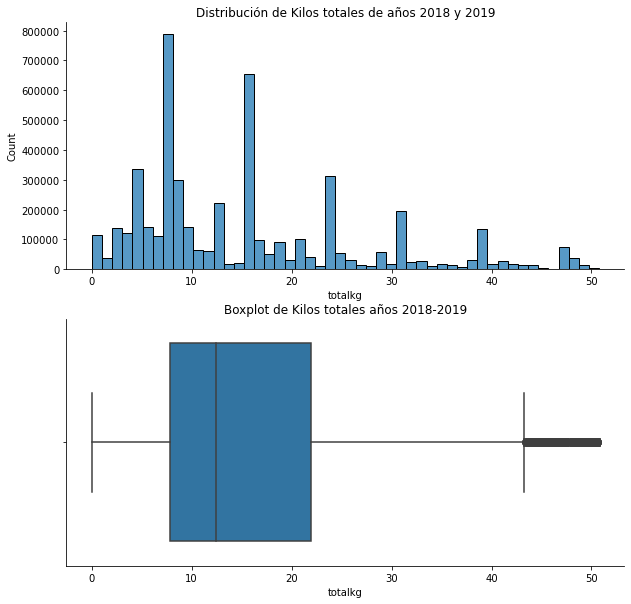

In [31]:
# distribución de los valores de 'totalkg' filtrados luego del análisis de exploración
fig,axes= plt.subplots(figsize=(10,10),nrows=2)

sns.histplot(df_final,x='totalkg',bins=50,ax=axes[0]).set(title="Distribución de Kilos totales de años 2018 y 2019")
sns.boxplot(x=df_final['totalkg']).set(title='Boxplot de Kilos totales años 2018-2019')
sns.despine()
plt.show()

Cambiamos los valores 'NaN' por 'otros' para agrupar aquellos registros que no poseen datos en las columnas categóricas
Según el experto de dominio, estos registros pertenecen a otros países
Limitamos el análisis solo para datos de Argentina



In [32]:
df_final=df_final.fillna('otros')

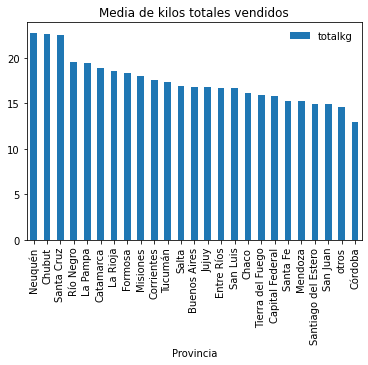

In [33]:
# Visualizamos la media de pedidos según Provincia
df_final.groupby("Provincia")["totalkg"].mean().sort_values(ascending=False).plot(kind="bar", legend="reverse")
plt.title('Media de kilos totales vendidos')
plt.legend(frameon=False)


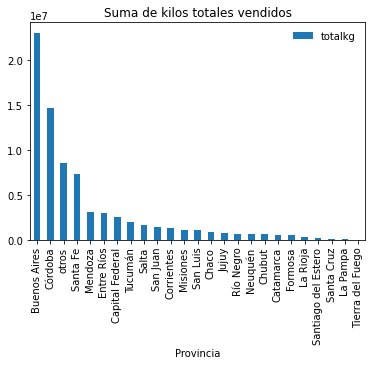

In [34]:
# Visualizamos la media de pedidos según Provincia
df_final.groupby("Provincia")["totalkg"].sum().sort_values(ascending=False).plot(kind="bar", legend="reverse")
plt.title('Suma de kilos totales vendidos')
plt.legend(frameon=False)


In [35]:
# Quitamos los registros 'otros' del análisis, creando un nuevo df: df_finalarg
df_finalarg= df_final[df_final['Provincia'] != 'otros']

<Figure size 1080x1080 with 0 Axes>

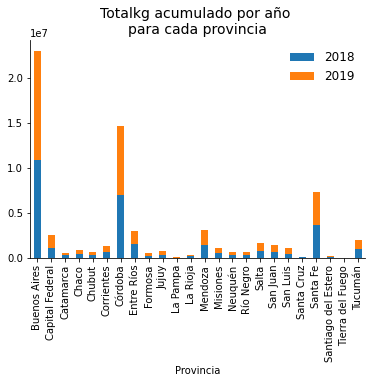

In [36]:
#Graficamos el total de Kg acumulados por año para cada provincia
dfdf=df_finalarg.groupby(['anio','Provincia'])["totalkg"].sum().round().sort_values(ascending=False).unstack('anio')

plt.figure(figsize= (15,15))
dfdf.plot(kind='bar', stacked=True)
plt.title('Totalkg acumulado por año \npara cada provincia', fontsize=14, pad=6)
plt.legend(frameon=False, fontsize=12)
sns.despine()

plt.show()


In [37]:
df_finalarg['totalkg'].describe().round()

count    4303250.0
mean          16.0
std           12.0
min            0.0
25%            8.0
50%           12.0
75%           22.0
max           51.0
Name: totalkg, dtype: float64

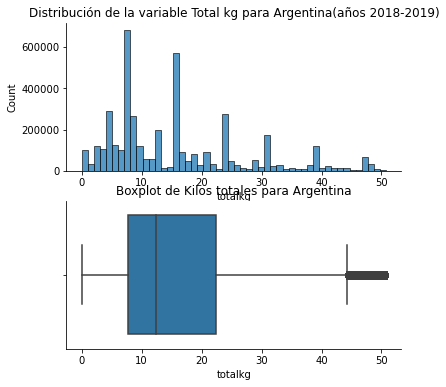

In [38]:
#Graficamos distribucion y hacemos un boxplot de totalkg para datos de Argentina
fig,axes= plt.subplots(figsize=(6,6),nrows=2)

sns.histplot(df_finalarg,x='totalkg',bins=50,ax=axes[0]).set(title="Distribución de la variable Total kg para Argentina(años 2018-2019)")
sns.boxplot(x=df_finalarg['totalkg']).set(title="Boxplot de Kilos totales para Argentina")
sns.despine()
plt.show()

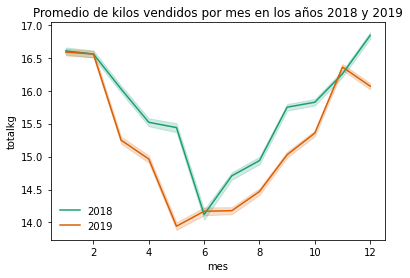

In [39]:
#Gráfico que muestra la variacion en totalkg solicitados por mes para cada año
sns.lineplot(data= df_finalarg, x='mes', y='totalkg', hue='anio', palette = 'Dark2')
plt.title('Promedio de kilos vendidos por mes en los años 2018 y 2019')
plt.legend(frameon=False)
plt.show()

# 1-  Cuales son las 3 provincias que mas kg solicitan por mes.

In [40]:
#Creamos la variable aniomes
df_finalarg['aniomes']=df_finalarg['anio'].astype(str) + df_finalarg['mes'].astype(str).str.pad(width=2,fillchar='0')

<ipython-input-40-c2d921b63ac0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_finalarg['aniomes']=df_finalarg['anio'].astype(str) + df_finalarg['mes'].astype(str).str.pad(width=2,fillchar='0')


In [41]:
#agrupamos por aniomes
grouped_aniomes=df_finalarg.groupby(by=['aniomes','Provincia'],as_index=False)['totalkg'].sum().round()
main_prov= grouped_aniomes.loc[grouped_aniomes.groupby(['aniomes'])['totalkg'].nlargest(3).reset_index()['level_1']]
main_prov.head()

aniomes     Provincia    totalkg
0   201801  Buenos Aires  1056322.0
6   201801       Córdoba   803346.0
20  201801      Santa Fe   427108.0
24  201802  Buenos Aires   999849.0
30  201802       Córdoba   645095.0

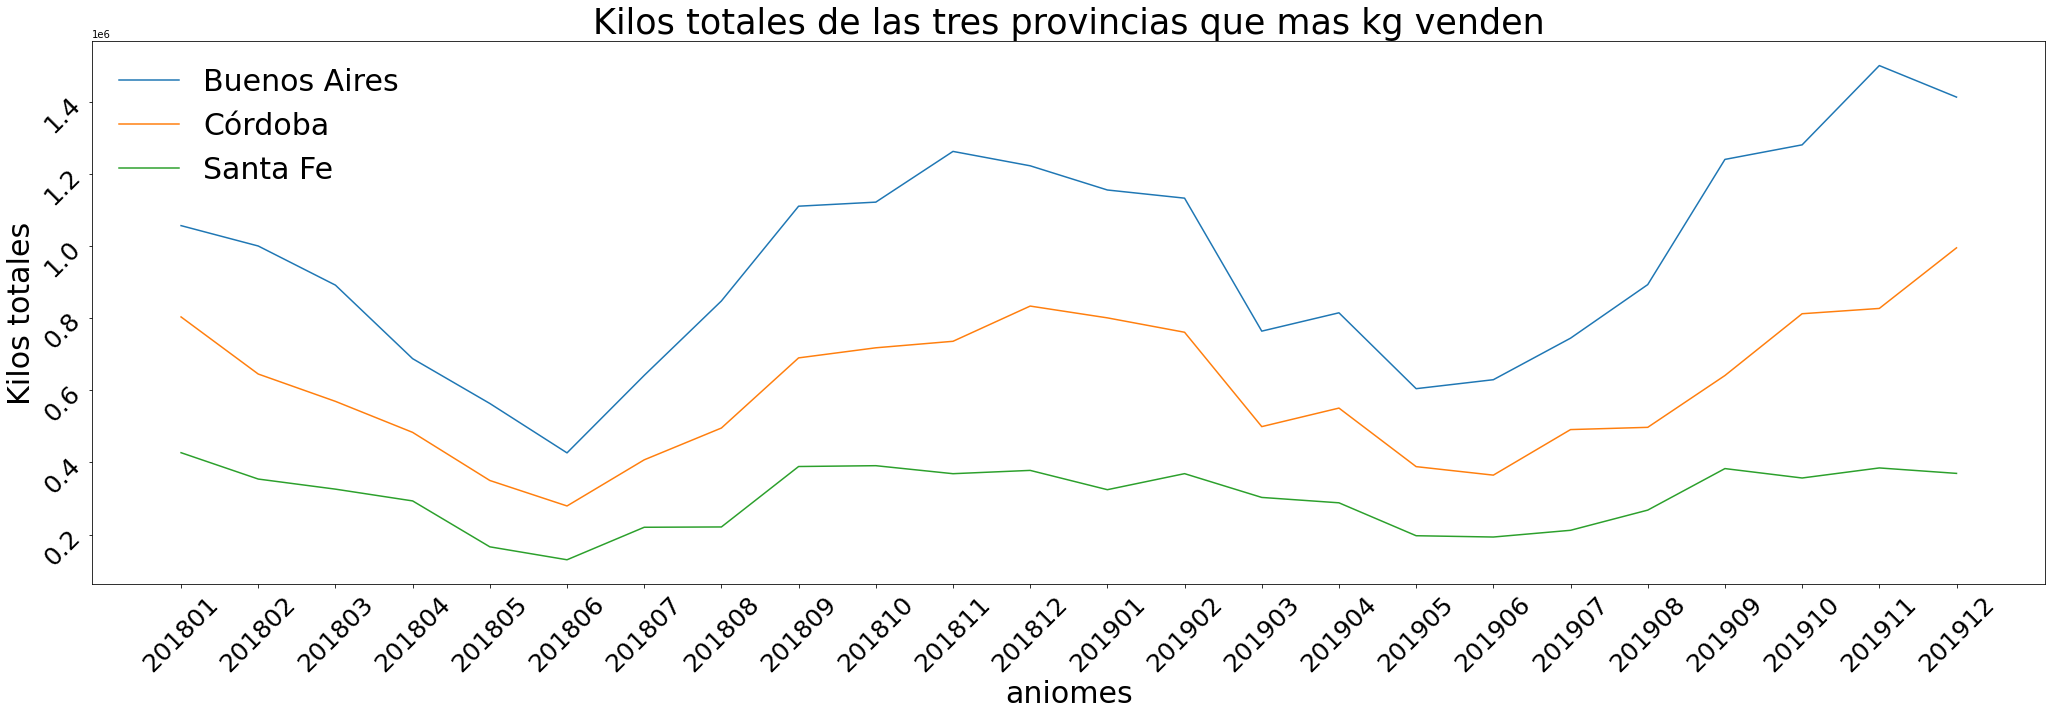

In [42]:
# Gráfico para visualizar las 3 principales provincias
fig=plt.figure(figsize=(35,10))
x=sns.lineplot(x="aniomes",
            y="totalkg",
            hue="Provincia",
            data=main_prov)
x.set_title("Kilos totales de las tres provincias que mas kg venden",fontsize=35)
x.set_xlabel("aniomes",fontsize=30)
x.set_ylabel("Kilos totales",fontsize=30)
x.tick_params(labelsize=25, rotation=45)
plt.legend(frameon=False, fontsize=30)
plt.show()

In [43]:
# Hago una nueva columna MES solo con el mes de la fecha
df_finalarg['MES'] = df_finalarg['fecha'].dt.month 

<ipython-input-43-0d2ca9910e9b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_finalarg['MES'] = df_finalarg['fecha'].dt.month


In [44]:
reg18=df_finalarg[df_finalarg["anio"]==2018]
reg19=df_finalarg[df_finalarg["anio"]==2019]

grouped_mes18_top3prov=reg18.groupby(by=['mes','Provincia'],as_index=False)['totalkg'].sum().round()
main_prov18= grouped_mes18_top3prov.loc[grouped_mes18_top3prov.groupby(['mes'])['totalkg'].nlargest(3).reset_index()['level_1']]
#main_prov18.head()
grouped_mes19_top3prov=reg19.groupby(by=['mes','Provincia'],as_index=False)['totalkg'].sum().round()
main_prov19= grouped_mes19_top3prov.loc[grouped_mes19_top3prov.groupby(['mes'])['totalkg'].nlargest(3).reset_index()['level_1']]
#main_prov19.head()

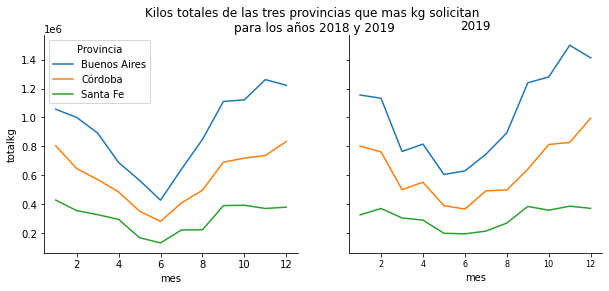

In [45]:
fig,axes = plt.subplots(1, 2, figsize= (10,4), sharey=True)

sns.lineplot(ax=axes[0],x="mes",y="totalkg",hue="Provincia",data=main_prov18)

sns.lineplot(ax=axes[1],x="mes",y="totalkg",hue="Provincia",data=main_prov19)

sns.despine()
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('2019', fontsize=12)
plt.legend().remove()
fig.suptitle("Kilos totales de las tres provincias que mas kg solicitan \npara los años 2018 y 2019", fontsize=12)
plt.show()

# 2- Cuales son las 3 localidades que mas kg solicitan por mes.

In [46]:
# Creamos una nueva columna que contenga el nombre de la Provincia concatenado con el nombre de la Localidad
# Para asegurarnos de que no existan 2 Localidades con el mismo nombre pertenecientes a Provincias diferentes

df_finalarg['locprov']=df_finalarg['Provincia'] + df_finalarg['Localidad'].str.pad(width=2,fillchar='0')


<ipython-input-46-3781237f792b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_finalarg['locprov']=df_finalarg['Provincia'] + df_finalarg['Localidad'].str.pad(width=2,fillchar='0')


In [47]:
reg18=df_finalarg[df_finalarg["anio"]==2018]
reg19=df_finalarg[df_finalarg["anio"]==2019]

In [48]:
grouped_mes18_top3L=reg18.groupby(by=['mes','locprov'],as_index=False)['totalkg'].sum().round()
main_loc18= grouped_mes18_top3L.loc[grouped_mes18_top3L.groupby(['mes'])['totalkg'].nlargest(3).reset_index()['level_1']]

grouped_mes19_top3L=reg19.groupby(by=['mes','locprov'],as_index=False)['totalkg'].sum().round()
main_loc19= grouped_mes19_top3L.loc[grouped_mes19_top3L.groupby(['mes'])['totalkg'].nlargest(3).reset_index()['level_1']]


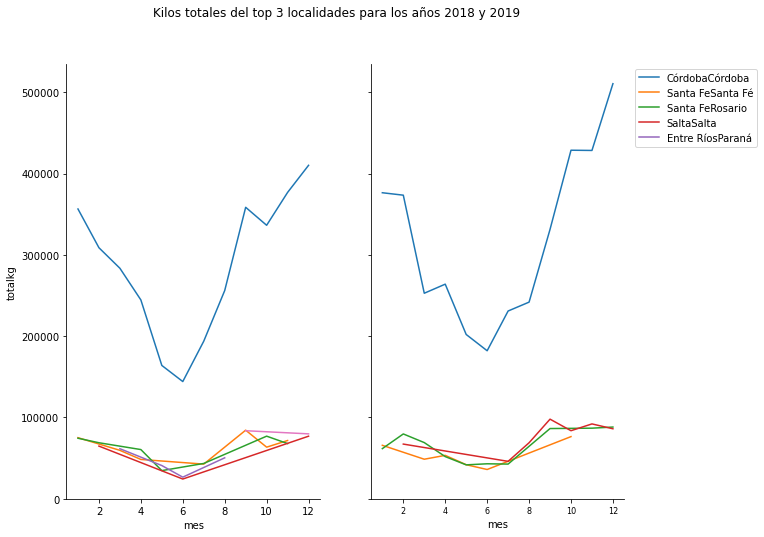

In [49]:
fig,axes = plt.subplots(1, 2, figsize= (10,8), sharey=True)

sns.lineplot(ax=axes[0],x="mes",y="totalkg",hue="locprov",data=main_loc18, legend=None)

sns.lineplot(ax=axes[1],x="mes",y="totalkg",hue="locprov",data=main_loc19)

sns.despine()
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
#plt.title('2019', fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 1))

fig.suptitle("Kilos totales del top 3 localidades para los años 2018 y 2019", fontsize=12)
plt.show()

# 3- Cuales son las 3 categorias que mas kg solicitan los clientes por mes.

In [50]:
grouped_cat_cuatri=df_finalarg.groupby('categoria')['totalkg'].sum().sort_values(ascending=False).round()
grouped_cat_cuatri.head()

categoria
07 - SABORES COMUNES                    14221639.0
08 - SABORES ESPECIALES                  8924152.0
17 - POTE 1 LTS                          7822207.0
09 - SABORES PREMIUM                     5523375.0
10 - PALITOS CREMA / FRUTAL / BOMBON     4970367.0
Name: totalkg, dtype: float64

In [51]:
# Extraemos el top 3 de las categorías que más se venden por mes
grouped_top3cat_18=reg18.groupby(by=['mes','categoria'],as_index=False)['totalkg'].sum().round()
main_cat_18=grouped_top3cat_18.loc[grouped_top3cat_18.groupby(['mes'])['totalkg'].nlargest(3).reset_index()['level_1']]

grouped_top3cat_19=reg19.groupby(by=['mes','categoria'],as_index=False)['totalkg'].sum().round()
main_cat_19= grouped_top3cat_19.loc[grouped_top3cat_19.groupby(['mes'])['totalkg'].nlargest(3).reset_index()['level_1']]


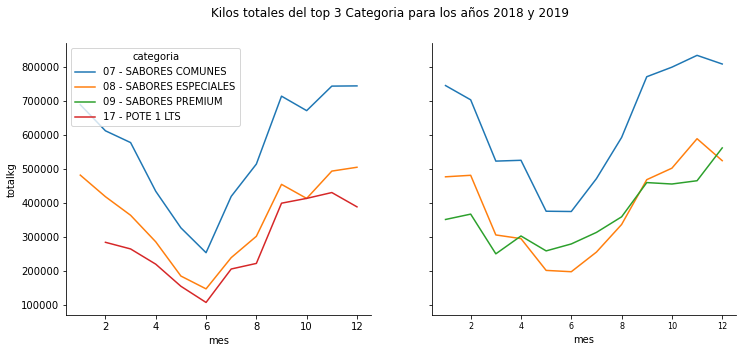

In [52]:
fig,axes = plt.subplots(1, 2, figsize= (12,5), sharey=True)

sns.lineplot(ax=axes[0],x="mes",y="totalkg",hue="categoria",data=main_cat_18)
sns.lineplot(ax=axes[1],x="mes",y="totalkg",hue="categoria",data=main_cat_19)

sns.despine()
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend().remove()
fig.suptitle("Kilos totales del top 3 Categoria para los años 2018 y 2019", fontsize=12)
plt.show()

# 4-  Existen productos que no se venden en todas las localidades?.


In [53]:
# Visualizamos la cantidad de productos únicos 'sku'

total_productos_unicos = len(df_finalarg['sku'].unique())
print('El total de productos unicos es: ', total_productos_unicos)

El total de productos unicos es:  422


In [54]:
# La cantidad de 'sku' solicitados por localidad

cant_skuporloc = df_finalarg.groupby('Localidad').agg({'sku':'nunique'})

# Se agrega la columna de 'dif_productos' que muestra la cantidad de 'sku' que no se solicitan en cada provincia

cant_skuporloc['dif_productos'] = total_productos_unicos-cant_skuporloc.sku  
cant_skuporloc.sort_values(['sku'], ascending=False)

sku  dif_productos
Localidad                                
Córdoba                411             11
San Miguel De Tucumán  397             25
Santa Fé               365             57
San Salvador De Jujuy  354             68
La Rioja               350             72
...                    ...            ...
Tilcara                  5            417
Hipólito Yrigoyen        4            418
Villa Regina             4            418
Rio Grande               4            418
Alderetes                2            420

[649 rows x 2 columns]

In [55]:
df_finalarg.groupby(['categoria','sku'])['sku'].count().sort_values(ascending=False)

categoria                           sku 
08 - SABORES ESPECIALES             1875    59166
07 - SABORES COMUNES                1696    58199
12 - IMPULSIVOS                     223     57198
06 - SABORES AL AGUA                263     56783
08 - SABORES ESPECIALES             1698    56659
                                            ...  
0013 - PRODUCTOS VIA BANA - TIPO A  1008        6
0001 - GRIDO MARKET                 1889        6
                                    1558        5
06 - PRODUCTOS DE LIMPIEZA          1502        4
0010 - PRODUCTOS PROMOCIONALES      932         4
Name: sku, Length: 422, dtype: int64

In [56]:
# Producto que menos se solicita
df_finalarg[df_finalarg['sku']=='932'][["categoria"]]

categoria
4659255  0010 - PRODUCTOS PROMOCIONALES
4676892  0010 - PRODUCTOS PROMOCIONALES
4677515  0010 - PRODUCTOS PROMOCIONALES
4691019  0010 - PRODUCTOS PROMOCIONALES

# 5- Existen productos que no se venden en todas las provincias?.

In [57]:
cant_skuporprov = df_finalarg.groupby('Provincia').agg({'sku':'nunique'})
cant_skuporprov['dif_productos'] =  total_productos_unicos-cant_skuporprov.sku 
cant_skuporprov.sort_values(['dif_productos'], ascending=False)

sku  dif_productos
Provincia                              
Tierra del Fuego     150            272
La Pampa             226            196
Santa Cruz           261            161
Neuquén              277            145
Formosa              281            141
Río Negro            290            132
Chubut               290            132
San Juan             298            124
Misiones             301            121
Corrientes           304            118
San Luis             304            118
Capital Federal      306            116
Entre Ríos           308            114
Chaco                312            110
Mendoza              313            109
Salta                314            108
La Rioja             364             58
Jujuy                367             55
Santiago del Estero  373             49
Catamarca            376             46
Buenos Aires         380             42
Santa Fe             395             27
Tucumán              400             22
Córdoba              415              7

# 6- Cuales son los 3 productos que mas kg solicitan los clientes por mes. Realice este análisis por localidad y por provincia agrupando los pedidos por mes.

In [58]:
sku_totales = df_finalarg[['sku','totalkg']].groupby(by=['sku'])['totalkg'].sum().sort_values(ascending=False).nlargest(5).reset_index()
sku_totales

sku    totalkg
0  1689  1411199.4
1  1693  1378962.0
2  1695  1343776.2
3  1687  1298848.2
4  1690  1288521.0

No handles with labels found to put in legend.


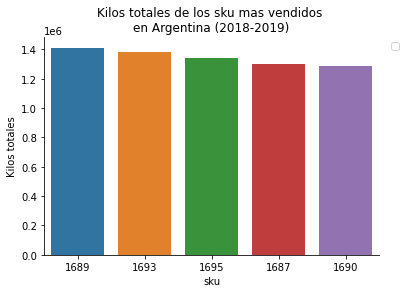

In [59]:
x=sns.barplot(x='sku',
           y="totalkg",
            data=sku_totales)
x.set_title("Kilos totales de los sku mas vendidos \nen Argentina (2018-2019)",fontsize=12)
x.set_xlabel("sku",fontsize=10)
x.set_ylabel("Kilos totales",fontsize=10)
x.tick_params(labelsize=10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left',fontsize=10)
sns.despine()
plt.show()

In [60]:
cba_filt=df_finalarg[df_finalarg['Provincia']=='Córdoba']

In [61]:
grupedsku_cba=cba_filt.groupby(by=['MES','sku'],as_index=False)['totalkg'].sum().round()
main_sku_cba=grupedsku_cba.loc[grupedsku_cba.groupby(['MES'])['totalkg'].nlargest(1).reset_index()['level_1']]
main_sku_cba.head()

MES   sku  totalkg
68      1  1689  43742.0
384     2  1689  40700.0
688     3  1689  32362.0
1156    4   334  27799.0
1475    5   334  22995.0

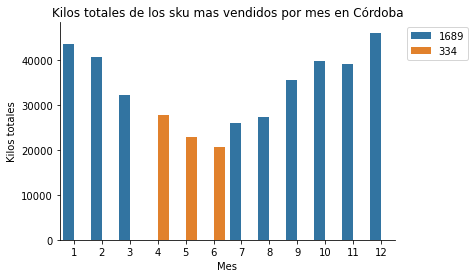

In [62]:
x=sns.barplot(x='MES',
           y="totalkg",
           hue='sku',
            data=main_sku_cba)
x.set_title("Kilos totales de los sku mas vendidos por mes en Córdoba",fontsize=12)
x.set_xlabel("Mes",fontsize=10)
x.set_ylabel("Kilos totales",fontsize=10)
x.tick_params(labelsize=10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left',fontsize=10)
sns.despine()
plt.show()

##1689 sabores comunes
##334 Impulsivos

In [63]:
BA_filt=df_finalarg[df_finalarg['Provincia']=='Buenos Aires']

In [64]:
grupedsku_BA=BA_filt.groupby(by=['MES','sku'],as_index=False)['totalkg'].sum().round()
main_sku_BA=grupedsku_BA.loc[grupedsku_BA.groupby(['MES'])['totalkg'].nlargest(1).reset_index()['level_1']]
main_sku_BA.head()

MES   sku  totalkg
151     1   263  44156.0
436     2   263  44164.0
633     3  1689  36598.0
900     4  1689  37136.0
1237    5   223  31805.0

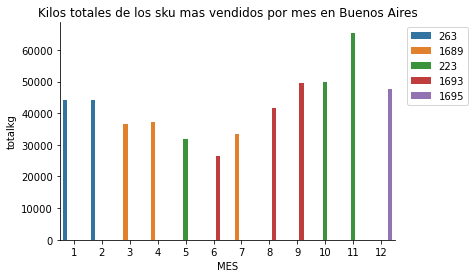

In [65]:
x=sns.barplot(x='MES',
           y="totalkg",
           hue='sku',
            data=main_sku_BA)
x.set_title("Kilos totales de los sku mas vendidos por mes en Buenos Aires",fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left',fontsize=10)
sns.despine()
plt.show()


263 sabores al agua en balde
1689 sabores comunes
223: impulsivos pack
1695: comunes baldes
1693: comunes baldes

In [66]:
SFe_filt=df_finalarg[df_finalarg['Provincia']=='Santa Fe']

In [67]:
grupedsku_SFe=BA_filt.groupby(by=['MES','sku'],as_index=False)['totalkg'].sum().round()
main_sku_SFe=grupedsku_SFe.loc[grupedsku_SFe.groupby(['MES'])['totalkg'].nlargest(1).reset_index()['level_1']]

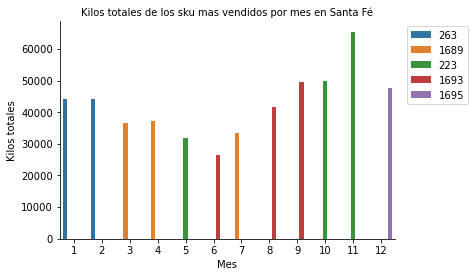

In [68]:
x=sns.barplot(x='MES',
           y="totalkg",
           hue='sku',
            data=main_sku_SFe)
x.set_title("Kilos totales de los sku mas vendidos por mes en Santa Fé",fontsize=10)
x.set_xlabel("Mes",fontsize=10)
x.set_ylabel("Kilos totales",fontsize=10)
x.tick_params(labelsize=10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left',fontsize=10)
sns.despine()
plt.show()

263 sabores al agua en balde
1689 sabores comunes
223: impulsivos pack
1695: comunes baldes
1693: comunes baldes

In [69]:
grouped_aniomes1=df_finalarg.groupby(by=['aniomes','Provincia','sku'],as_index=False)['totalkg'].sum().round()
main_prov= grouped_aniomes1.loc[grouped_aniomes1.groupby(['aniomes'])['totalkg'].nlargest(3).reset_index()['level_1']]
main_prov.head()

aniomes     Provincia   sku  totalkg
142   201801  Buenos Aires   263  21130.0
180   201801  Buenos Aires   318  21037.0
1409  201801       Córdoba   888  20525.0
4343  201802  Buenos Aires   263  20803.0
4274  201802  Buenos Aires  1695  18923.0

# 7- El producto que mas se pide pertenece a la categoria que mas se vende?

In [70]:
df_finalarg.groupby(["sku"])["totalkg"].sum().sort_values(ascending=False).round()[:3]


sku
1689    1411199.0
1693    1378962.0
1695    1343776.0
Name: totalkg, dtype: float64

In [71]:
totalcat= df_finalarg['totalkg'].sum()
totalcat

67248193.24540003

In [72]:
kilosporcat=df_finalarg.groupby(["categoria"])["totalkg"].sum().sort_values(ascending=False).round()
kilosporcat.head(3)

categoria
07 - SABORES COMUNES       14221639.0
08 - SABORES ESPECIALES     8924152.0
17 - POTE 1 LTS             7822207.0
Name: totalkg, dtype: float64

In [73]:
participacionekilosporcat=(kilosporcat/totalcat)*100
participacionekilosporcat.head(3)

categoria
07 - SABORES COMUNES       21.147987
08 - SABORES ESPECIALES    13.270471
17 - POTE 1 LTS            11.631847
Name: totalkg, dtype: float64

In [74]:
ventas_df_sku1689=df_finalarg[df_finalarg['sku']=='1689'][['categoria','sku']]
ventas_df_sku1689[:1].T

2898
categoria  07 - SABORES COMUNES
sku                        1689

#### De acuerdo al analisis realizado se puede confirmar que el producto que mas se pide pertenece a la categoria que mas se vende ('07 - SABORES COMUNES')

Estaría bueno hacer un grafico de la info en participacionekilosporcat

# 8- El producto que mas se pide se vende en todas las localidades?


In [75]:
total_localidades = len(df_finalarg['locprov'].unique())
print("El total de localidades es", total_localidades)

El total de localidades es 658


In [76]:
df_localidad = df_finalarg[["locprov", "sku"]]
df_localidad.head()

locprov   sku
2886  CórdobaMontecristo   266
2887  CórdobaMontecristo   263
2888  CórdobaMontecristo   861
2889  CórdobaMontecristo  1103
2890  CórdobaMontecristo  1695

In [77]:
df_localidadsku1689=df_localidad[df_localidad['sku']=='1689']
Totallocsku1689=df_localidadsku1689["locprov"].nunique()
Totallocsku1689

607

In [78]:
difloc1689 = total_localidades - Totallocsku1689
print("El numero de localidades que no venden el producto mas vendido a nivel nacional (sku=1689) es:", difloc1689)

El numero de localidades que no venden el producto mas vendido a nivel nacional (sku=1689) es: 51


# 9- Seleccionar 4 variables que consideren de interes para el objetivo del proyecto. Una de las variables debe ser "totalkg".

In [79]:
variables_elegidas = df_finalarg[["totalkg", "locprov", "sku" , "id_punto_venta" ,'fecha']]

# 10- Para las variables de interes seleccionadas indicar que tipo de variable es cada una.

In [80]:
variables_elegidas.dtypes

# 'totalkg' es variable numérica continua
# fecha es Daytime
#El resto de las variables son categóricas

totalkg                  float64
locprov                   object
sku                       object
id_punto_venta            object
fecha             datetime64[ns]
dtype: object

# 11- De las 3 categorias mas pedidas de productos analizar la dispersión de totalkg de dichas categorias. Realizar este análisis también no solo a nivel nacional sino tambien por provincia (las 3 provincias que mas piden) y por localidad (las 3 localidades que mas piden)

In [81]:
filt_cat_sabcom= df_finalarg[df_finalarg["categoria"]=="07 - SABORES COMUNES"]
filt_cat_sabcom['totalkg'].describe()

count    683517.000000
mean         20.806562
std          11.672715
min           7.800000
25%           7.800000
50%          15.600000
75%          31.200000
max          46.800000
Name: totalkg, dtype: float64

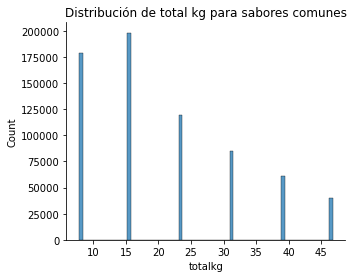

In [82]:
plt.figure(figsize=(5,4))
x=sns.histplot(x=filt_cat_sabcom['totalkg'])
x.set_title("Distribución de total kg para sabores comunes",fontsize=12)
x.set_xlabel("totalkg")
x.set_ylabel("Count")
sns.despine()
plt.show()

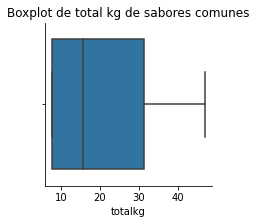

In [83]:
plt.figure(figsize=(3,3))
sns.boxplot(x=filt_cat_sabcom['totalkg']).set(title="Boxplot de total kg de sabores comunes")
sns.despine()
plt.show()

In [84]:
filt_cat_sabesp= df_finalarg[df_finalarg["categoria"]=="08 - SABORES ESPECIALES"]
filt_cat_sabesp['totalkg'].describe().round()

count    533144.0
mean         17.0
std          10.0
min           8.0
25%           8.0
50%          16.0
75%          23.0
max          47.0
Name: totalkg, dtype: float64

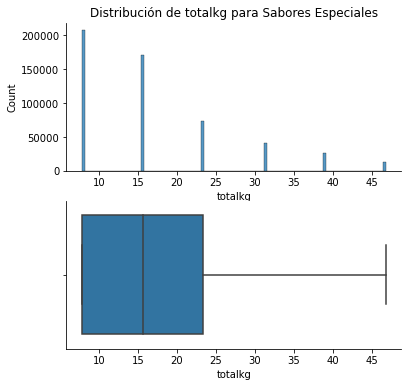

In [85]:
fig,axes=plt.subplots(figsize= (6,6), nrows=2)
distSabEsp= filt_cat_sabesp['totalkg']
sns.histplot(x=distSabEsp, ax=axes[0]).set(title="Distribución de totalkg para Sabores Especiales")
sns.boxplot(x=distSabEsp, ax=axes[1])

sns.despine()
plt.show()

In [86]:
filt_cat_pot= df_finalarg[df_finalarg["categoria"]=="17 - POTE 1 LTS"]
filt_cat_pot['totalkg'].describe().round()

count    628955.0
mean         12.0
std          10.0
min           4.0
25%           4.0
50%           8.0
75%          17.0
max          50.0
Name: totalkg, dtype: float64

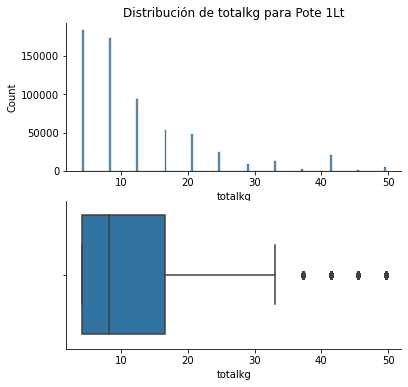

In [87]:
fig,axes=plt.subplots(figsize= (6,6), nrows=2)
distpot= filt_cat_pot['totalkg']
sns.histplot(x=distpot, ax=axes[0]).set(title="Distribución de totalkg para Pote 1Lt")
sns.boxplot(x=distpot, ax=axes[1])
sns.despine()

In [88]:
df_tres_prov= df_finalarg[(df_finalarg['Provincia']=='Córdoba') | (df_finalarg['Provincia']=='Buenos Aires') | (df_finalarg['Provincia']=='Santa Fe')]

In [89]:
filt_cat_sabcom_p= df_tres_prov[df_tres_prov["categoria"]=="07 - SABORES COMUNES"]
filt_cat_sabcom_p['totalkg'].describe()

count    483560.000000
mean         20.073547
std          11.494707
min           7.800000
25%           7.800000
50%          15.600000
75%          31.200000
max          46.800000
Name: totalkg, dtype: float64

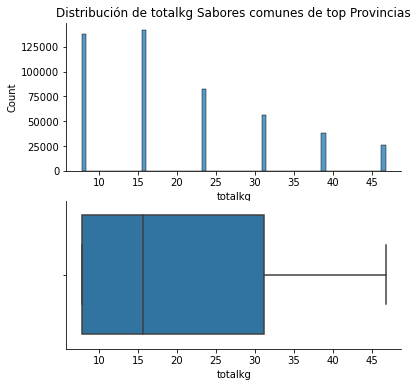

In [90]:
fig,axes=plt.subplots(figsize= (6,6), nrows=2)
datasabcom_p= filt_cat_sabcom_p['totalkg']
sns.histplot(x=datasabcom_p, ax=axes[0]).set(title="Distribución de totalkg Sabores comunes de top Provincias")
sns.boxplot(x=datasabcom_p, ax=axes[1])
sns.despine()

In [91]:
filt_cat_sabesp_p= df_tres_prov[df_tres_prov["categoria"]=="08 - SABORES ESPECIALES"]
filt_cat_sabesp_p['totalkg'].describe()

count    368290.000000
mean         15.911310
std           9.607163
min           7.800000
25%           7.800000
50%          15.600000
75%          23.400000
max          46.800000
Name: totalkg, dtype: float64

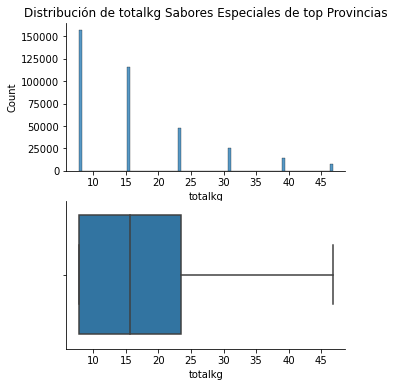

In [92]:
fig,axes=plt.subplots(figsize= (5,6), nrows=2)
datasabesp_p= filt_cat_sabesp_p['totalkg']
sns.histplot(x=datasabesp_p, ax=axes[0]).set(title="Distribución de totalkg Sabores Especiales de top Provincias")
sns.boxplot(x=datasabesp_p, ax=axes[1])
sns.despine()

In [93]:
filt_pot1lt_p= df_tres_prov[df_tres_prov["categoria"]=="17 - POTE 1 LTS"]
filt_pot1lt_p['totalkg'].describe()

count    437967.000000
mean         11.519747
std           9.011691
min           4.140000
25%           4.140000
50%           8.280000
75%          12.420000
max          49.680000
Name: totalkg, dtype: float64

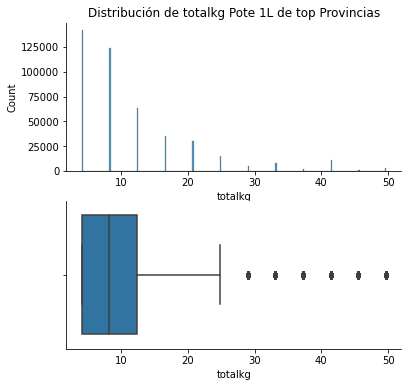

In [94]:
fig,axes=plt.subplots(figsize= (6,6), nrows=2)
dist_pote1lt_p=filt_pot1lt_p['totalkg']
sns.histplot(x=dist_pote1lt_p, ax=axes[0]).set(title="Distribución de totalkg Pote 1L de top Provincias")
sns.boxplot(x=dist_pote1lt_p, ax=axes[1])
sns.despine()

In [95]:
#Hacemos lo mismo por la top localidades
df_cuatro_loc= df_finalarg[(df_finalarg['locprov']=='CórdobaCórdoba') | (df_finalarg['locprov']=='Santa FeSanta Fé') | (df_finalarg['locprov']=='Santa FeRosario')|(df_finalarg['locprov']=='SaltaSalta')]

In [96]:
#Categoria Sabores comunes
filt_cat_sabcom_l= df_cuatro_loc[df_cuatro_loc["categoria"]=="07 - SABORES COMUNES"]
filt_cat_sabcom_l['totalkg'].describe()

count    148266.000000
mean         16.612444
std           9.948995
min           7.800000
25%           7.800000
50%          15.600000
75%          23.400000
max          46.800000
Name: totalkg, dtype: float64

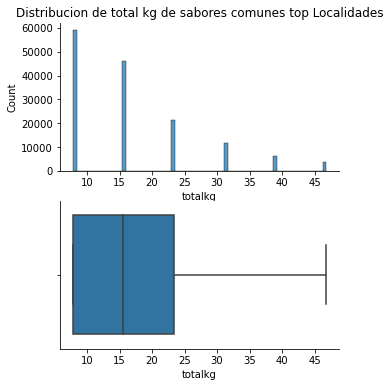

In [97]:
fig,axes=plt.subplots(figsize= (5,6), nrows=2)
datasabcom_l= filt_cat_sabcom_l['totalkg']
sns.histplot(x=datasabcom_l, ax=axes[0]).set(title="Distribucion de total kg de sabores comunes top Localidades")
sns.boxplot(x=datasabcom_l, ax=axes[1])
sns.despine()
plt.show()

In [98]:
filt_cat_sabesp_l= df_cuatro_loc[df_cuatro_loc["categoria"]=="08 - SABORES ESPECIALES"]
filt_cat_sabesp_l['totalkg'].describe()

count    111157.000000
mean         13.233412
std           7.445847
min           7.800000
25%           7.800000
50%           7.800000
75%          15.600000
max          46.800000
Name: totalkg, dtype: float64

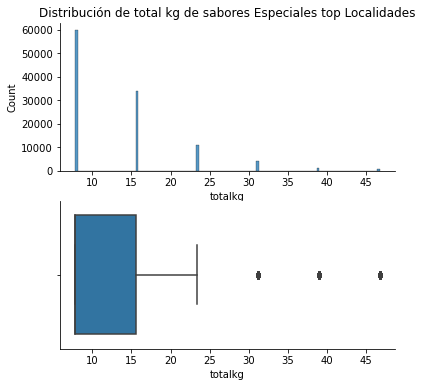

In [99]:
fig,axes=plt.subplots(figsize= (6,6), nrows=2)
datasabesp_l= filt_cat_sabesp_l['totalkg']
sns.histplot(x=datasabesp_l, ax=axes[0]).set(title="Distribución de total kg de sabores Especiales top Localidades")
sns.boxplot(x=datasabesp_l, ax=axes[1])
sns.despine()

In [100]:
filt_pot1lt_l= df_cuatro_loc[df_cuatro_loc["categoria"]=="17 - POTE 1 LTS"]
filt_pot1lt_l['totalkg'].describe()

count    130889.000000
mean          9.351335
std           7.391365
min           4.140000
25%           4.140000
50%           8.280000
75%          12.420000
max          49.680000
Name: totalkg, dtype: float64

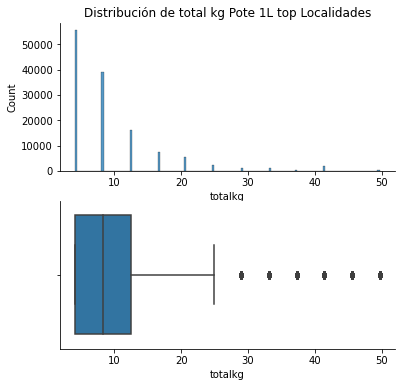

In [101]:
fig,axes=plt.subplots(figsize= (6,6), nrows=2)
dist_pote1lt_l=filt_pot1lt_l['totalkg']
sns.histplot(x=dist_pote1lt_l, ax=axes[0]).set(title="Distribución de total kg Pote 1L top Localidades")
sns.boxplot(x=dist_pote1lt_l, ax=axes[1])
sns.despine()

# 12- Determine si hay outliers en las variables seleccionadas. Realice este análisis por distintas variables como por ejemplo totalkg por provincia para cada mes.

variables_elegidas = df_finalarg[["totalkg", "locprov", "sku" , "id_punto_venta" ,'fecha']]
De las variables elegidas solo total kg era analizable era la unica variable numérica. Por esta variable decidimos analizar los valores de la variable cantidad pedida solo a fin de complementar el análisis y encontrar comportamiento de compra.


In [102]:
df_finalarg[df_finalarg["cantidad_pedida"]>100]

dia  mes  anio              hora   sku  cantidad_pedida  \
4931600   30    8  2018  18:28:45.0000000   433            108.0   
5046646    2   11  2018  18:38:28.0000000  1522            200.0   
5502949   17   10  2019  17:21:00.7800000  1909            120.0   

        id_punto_venta      fecha          descripcion        marca  ...  \
4931600         100628 2018-08-30  CAPSXX-XX-X-XXXnid.  SIN DEFINIR  ...   
5046646         100476 2018-11-02  BOCHXX-XX-X-XXX grs        GRIDO  ...   
5502949         100817 2019-10-17  RESOXX-XX-X-XXXunid  SIN DEFINIR  ...   

         id_Provincia id_Localidad  id_Pais     Localidad  Provincia  \
4931600          15.0       3628.0      1.0  General Roca  Río Negro   
5046646          10.0       2911.0      1.0  General Acha   La Pampa   
5502949          14.0       3545.0      1.0       Neuquen    Neuquén   

              Pais totalkg aniomes MES                locprov  
4931600  Argentina   31.32  201808   8  Río NegroGeneral Roca  
5046646  Argentina   34.00  201811  11   La PampaGeneral Acha  
5502949  Argentina    2.40  201910  10         NeuquénNeuquen  

[3 rows x 27 columns]

In [103]:
df_finalarg["cantidad_pedida"].describe().round()

count    4303250.0
mean           3.0
std            2.0
min            0.0
25%            1.0
50%            2.0
75%            4.0
max          200.0
Name: cantidad_pedida, dtype: float64

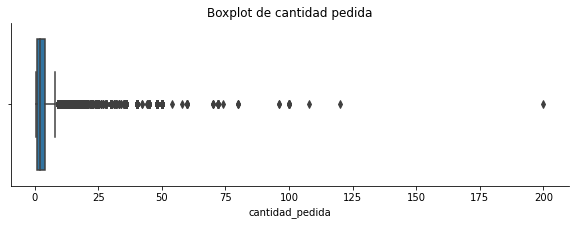

In [104]:
plt.figure(figsize=(10,3))
sns.boxplot(x=df_finalarg["cantidad_pedida"]).set(title="Boxplot de cantidad pedida")
sns.despine()
plt.show()

In [105]:
Q_1 = df_finalarg['cantidad_pedida'].quantile(0.25)
Q_3 = df_finalarg['cantidad_pedida'].quantile(0.75)

IQR_b = Q_3 - Q_1                    
BI_Calculadob = (Q_1 - 1.5* IQR_b)
BS_Calculadob = (Q_3 + 1.5* IQR_b)                

ubic_outliersb = (df_finalarg['cantidad_pedida'] < BI_Calculadob) | (df_finalarg['cantidad_pedida'] > BS_Calculadob)
outliersb = df_finalarg[ubic_outliersb]

ubic_sin_outliersb = (df_finalarg['cantidad_pedida'] >= BI_Calculadob) & (df_finalarg['cantidad_pedida'] <= BS_Calculadob)
df_final2 = df_finalarg[ubic_sin_outliersb]

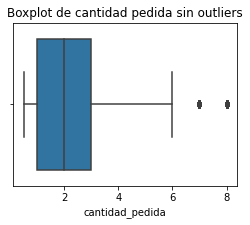

In [106]:
plt.figure(figsize=(4,3))
sns.boxplot(x=df_final2["cantidad_pedida"]).set(title="Boxplot de cantidad pedida sin outliers")
plt.show()

In [107]:
df_final2["cantidad_pedida"].describe().round()

count    4123976.0
mean           3.0
std            2.0
min            0.0
25%            1.0
50%            2.0
75%            3.0
max            8.0
Name: cantidad_pedida, dtype: float64

In [108]:
cant_ped_cba=df_finalarg[df_finalarg["Provincia"]=='Córdoba']
cant_ped_cba['cantidad_pedida'].describe().round()

count    1133919.0
mean           2.0
std            2.0
min            0.0
25%            1.0
50%            2.0
75%            3.0
max          100.0
Name: cantidad_pedida, dtype: float64

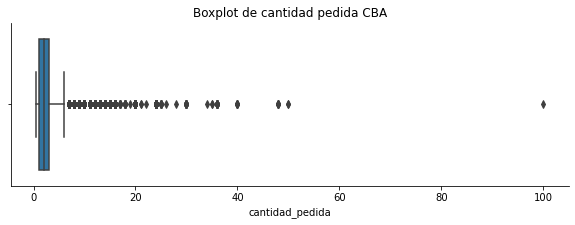

In [109]:
plt.figure(figsize=(10,3))
sns.boxplot(x=cant_ped_cba["cantidad_pedida"]).set(title="Boxplot de cantidad pedida CBA")
sns.despine()
plt.show()

In [110]:
cant_ped_ba=df_finalarg[df_finalarg["Provincia"]=='Buenos Aires']
cant_ped_ba['cantidad_pedida'].describe().round()

count    1368898.0
mean           3.0
std            3.0
min            1.0
25%            1.0
50%            2.0
75%            4.0
max           50.0
Name: cantidad_pedida, dtype: float64

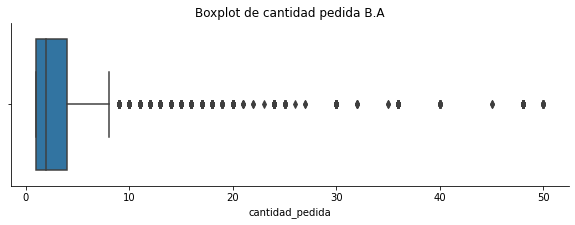

In [111]:
plt.figure(figsize=(10,3))
sns.boxplot(x=cant_ped_ba["cantidad_pedida"]).set(title="Boxplot de cantidad pedida B.A")
sns.despine()
plt.show()

In [112]:
cant_ped_sf=df_finalarg[df_finalarg["Provincia"]=='Santa Fe']
cant_ped_sf['cantidad_pedida'].describe().round()

count    478717.0
mean          3.0
std           2.0
min           1.0
25%           1.0
50%           2.0
75%           4.0
max         100.0
Name: cantidad_pedida, dtype: float64

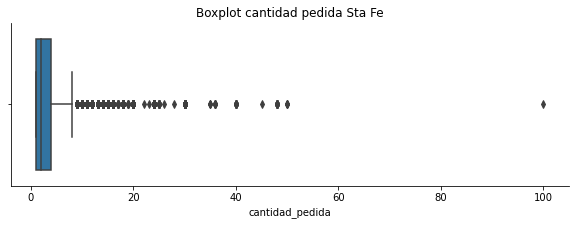

In [113]:
plt.figure(figsize=(10,3))
sns.boxplot(x=cant_ped_sf["cantidad_pedida"]).set(title="Boxplot cantidad pedida Sta Fe")
sns.despine()
plt.show()


En los boxplots de cantidad pedida por provincia se observa que hay mas outliers en Córdoba y Santa Fe.

 Hacemos la exploracion de outliers en totalkg de las 3 provincias con mas ventas de kilos totales

In [114]:
cant_totalkg_cba=df_finalarg[df_finalarg["Provincia"]=='Córdoba']
cant_totalkg_cba['totalkg'].describe().round()

count    1133919.0
mean          13.0
std           10.0
min            0.0
25%            8.0
50%            8.0
75%           16.0
max           51.0
Name: totalkg, dtype: float64

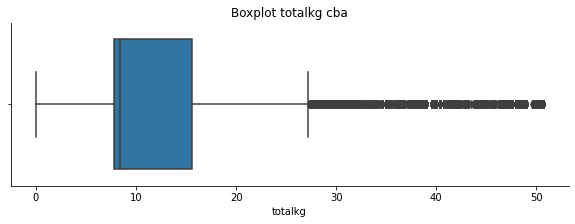

In [115]:
plt.figure(figsize=(10,3))
sns.boxplot(x=cant_totalkg_cba["totalkg"]).set(title="Boxplot totalkg cba")
sns.despine()
plt.show()

In [116]:
cant_totalkg_ba=df_finalarg[df_finalarg["Provincia"]=='Buenos Aires']
cant_totalkg_ba['totalkg'].describe().round()

count    1368898.0
mean          17.0
std           12.0
min            0.0
25%            8.0
50%           16.0
75%           23.0
max           51.0
Name: totalkg, dtype: float64

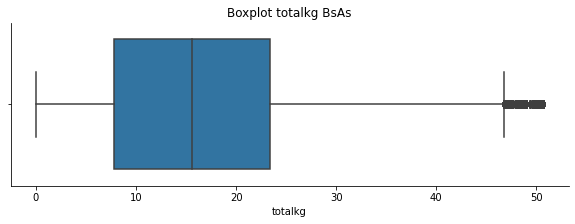

In [117]:
plt.figure(figsize=(10,3))
sns.boxplot(x=cant_totalkg_ba['totalkg']).set(title="Boxplot totalkg BsAs")
sns.despine()
plt.show()

In [118]:
cant_totalkg_sf=df_finalarg[df_finalarg["Provincia"]=='Santa Fe']
cant_totalkg_sf['totalkg'].describe().round()

count    478717.0
mean         15.0
std          11.0
min           0.0
25%           8.0
50%          12.0
75%          21.0
max          51.0
Name: totalkg, dtype: float64

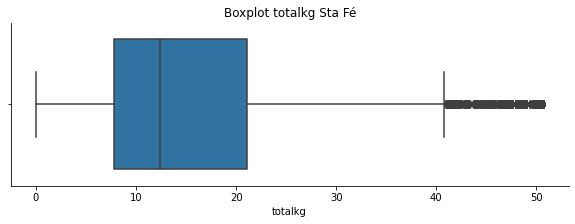

In [119]:

plt.figure(figsize=(10,3))
sns.boxplot(x=cant_totalkg_sf['totalkg']).set(title="Boxplot totalkg Sta Fé")
sns.despine()
plt.show()

# 13 -Determinar si hay valores faltantes e indicar que tratamiento darle en tal caso. Indicar cuales son las features con mas valores faltantes. Conviene descartarlos o completarlos con un valor en particular?

Código para la consigna desarrollado al inicio (tratamiento de datos faltantes de nombre e id correpondientes a País, Provincia, Localidad y puntos de venta. Dado que son valores que no se pueden inferir por otras variables y que corresponden a datos de otros países (segun el experto de dominio) el tratamiento consistió en ponerlos bajo el valor "otros" para luego analizarlos aparte.

# 14- Calcule la media y la mediana de totalkg por mes del producto mas vendido y de la categoria mas vendida. Realice este análisis por localidad y por provincia agrupando los pedidos por mes.

In [120]:
skumasvendido=df_finalarg[df_finalarg['sku']=='1689']
skumasvendidoprovincia_mean= skumasvendido.groupby(['aniomes', "Provincia"]).agg({'totalkg':"mean"}).round().sort_values(by="totalkg", ascending=False)
skumasvendidoprovincia_mean = skumasvendidoprovincia_mean.rename(columns = {'totalkg' : 'promedio'})
skumasvendidoprovincia_mean.head()

promedio
aniomes Provincia                    
201811  Chubut                   47.0
201902  Santiago del Estero      47.0
201808  La Pampa                 47.0
201903  Santa Cruz               47.0
201905  Santiago del Estero      47.0

In [121]:
skumasvendidoprovincia_median= skumasvendido.groupby(['aniomes', "Provincia"]).agg({'totalkg':"median"}).round().sort_values(by="totalkg", ascending= False)
skumasvendidoprovincia_median = skumasvendidoprovincia_median.rename(columns = {'totalkg' : 'mediana'})
skumasvendidoprovincia_median.head()

mediana
aniomes Provincia          
201903  Santa Cruz     47.0
201908  La Pampa       47.0
201809  La Pampa       47.0
        La Rioja       47.0
201812  Chubut         47.0

In [122]:
skumasvendidolocalidad_mean= skumasvendido.groupby(['aniomes', "Localidad"]).agg({'totalkg':"mean"}).round().sort_values(by="totalkg", ascending= False)
skumasvendidolocalidad_mean = skumasvendidolocalidad_mean.rename(columns = {'totalkg' : 'promedio'})
skumasvendidolocalidad_mean[:10]

promedio
aniomes Localidad                          
201901  La Boca                        47.0
201903  San Justo                      47.0
201904  3 De Febrero, Ciudadela        47.0
201903  Zapala                         47.0
201803  Lomas De Zamora, Lavallol      47.0
201903  Villa María De Río Seco        47.0
        Villa Elisa                    47.0
        Vicente López, Munro           47.0
        Urdinarrain                    47.0
201803  Malagueño                      47.0

In [123]:
skumasvendidolocalidad_median= skumasvendido.groupby(['aniomes', "Localidad"]).agg({'totalkg':"median"}).round().sort_values(by="totalkg", ascending= False)
skumasvendidolocalidad_median = skumasvendidolocalidad_median.rename(columns = {'totalkg' : 'mediana'})
skumasvendidolocalidad_median[:10]

mediana
aniomes Localidad                                    
201901  La Boca                                  47.0
201902  Arias                                    47.0
201901  San Jose De Feliciano                    47.0
201908  Villa Gesell, Villa Gesel                47.0
201901  San Justo                                47.0
201805  Capitán Sarmiento, Capitan Sarmiento     47.0
201908  Tilisarao                                47.0
201901  Tigre, General Pacheco                   47.0
201908  Sumampa                                  47.0
201901  Tigre, Troncos Del Talar                 47.0

In [124]:
catmasvendida=df_finalarg[df_finalarg['categoria']=='07 - SABORES COMUNES']

In [125]:
catmasvendidaprovincia_mean=catmasvendida.groupby(['aniomes', "Provincia"]).agg({'totalkg':"mean"}).round().sort_values(by="totalkg", ascending= False)
catmasvendidaprovincia_mean=catmasvendidaprovincia_mean.rename(columns={'totalkg':'promedio'})
catmasvendidaprovincia_mean[:10]

promedio
aniomes Provincia                 
201911  La Pampa              44.0
201903  Santa Cruz            42.0
201901  Santa Cruz            41.0
201912  Santa Cruz            40.0
201907  Santa Cruz            40.0
201801  Tierra del Fuego      39.0
201802  Santa Cruz            39.0
201803  Santa Cruz            39.0
201806  Tierra del Fuego      39.0
201811  Santa Cruz            39.0

In [126]:
catmasvendidaprovincia_median= catmasvendida.groupby(['aniomes', "Provincia"]).agg({'totalkg':"median"}).round().sort_values(by="totalkg", ascending= False)
catmasvendidaprovincia_median=catmasvendidaprovincia_median.rename(columns={'totalkg':'mediana'})
catmasvendidaprovincia_median[:10]

mediana
aniomes Provincia          
201911  La Pampa       47.0
201910  La Pampa       47.0
201901  Santa Cruz     43.0
201807  Santa Cruz     39.0
201908  Neuquén        39.0
201910  Chubut         39.0
201905  Santa Cruz     39.0
201906  Chubut         39.0
201811  Santa Cruz     39.0
201902  Santa Cruz     39.0

In [127]:
catmasvendidalocalidad_median= catmasvendida.groupby(['aniomes', "Localidad"]).agg({'totalkg':"median"}).round().sort_values(by="totalkg", ascending= False)
catmasvendidalocalidad_median=catmasvendidalocalidad_median.rename(columns={'totalkg':'mediana'})
catmasvendidalocalidad_median.head()

mediana
aniomes Localidad                                   
201910  Malvinas Argentinas, Los Polvorines     47.0
201902  Gualeguaychu                            47.0
        Cutral Co                               47.0
201804  Malvinas Argentinas, Tortuguitas        47.0
201809  Cutral Co                               47.0

In [128]:
catmasvendidalocalidad_mean= catmasvendida.groupby(['aniomes', "Localidad"]).agg({'totalkg':"mean"}).round().sort_values(by="totalkg", ascending= False)
catmasvendidalocalidad_mean=catmasvendidalocalidad_mean.rename(columns={'totalkg':'promedio'})
catmasvendidalocalidad_mean.head()

promedio
aniomes Localidad                                    
201809  Villa Larroque                           47.0
201908  Malvinas Argentinas, Los Polvorines      47.0
201811  Rafaela                                  47.0
201911  Laferrere                                47.0
201907  Cutral Co                                47.0

# 15- Cuál es la provincia con mayor promedio de totalkg por mes? Y de menor promedio por mes?

In [129]:
df_finalarg.groupby(["Provincia"])["totalkg"].mean().sort_values(ascending=False).head(1)

Provincia
Neuquén    22.783514
Name: totalkg, dtype: float64

In [130]:
df_finalarg.groupby("Provincia")["totalkg"].mean().sort_values(ascending=True).head(1)

Provincia
Córdoba    12.910089
Name: totalkg, dtype: float64

# 16- Que distribución tiene la variable totalkg?. Que implicancias tiene la distribución de dicha variable?

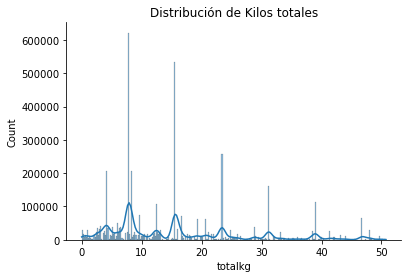

In [131]:
# Para ver la distribución de los valores de 'totalkg' filtrados luego del análisis de exploración
sns.histplot(df_finalarg,x='totalkg', kde = True)
plt.title('Distribución de Kilos totales')
sns.despine()
plt.show()

In [132]:
df_finalarg['totalkg'].mean()

15.627303374284518

In [133]:
df_finalarg['totalkg'].median()

12.419999999999998

#### Distribución asimétrica a la derecha (sesgada de forma positiva), dado que la media es mayor a la mediana y los valores se concentran hacia valores mas pequeños totalkg. Como la distribución tiene cola conviene trabajar con la mediana, un estimador puntual que no es tan sensible a valores extremos.

# 17- Cual es la frecuencia de las variables categóricas que seleccionaron?

### Frecuencia de Sku

In [134]:
sku_count = df_finalarg.sku.value_counts(ascending=False)\
    .reset_index()\
    .rename(columns={'index': 'sku', 'sku': 'frecuencia'})
sku_count['frec_relativa']= (sku_count['frecuencia']/(sku_count['frecuencia'].sum()))*100
sku_count

sku  frecuencia  frec_relativa
0    1875       59166       1.374914
1    1696       58199       1.352443
2     223       57198       1.329181
3     263       56783       1.319538
4    1698       56659       1.316656
..    ...         ...            ...
417  1008           6       0.000139
418  1889           6       0.000139
419  1558           5       0.000116
420   932           4       0.000093
421  1502           4       0.000093

[422 rows x 3 columns]

In [135]:
frec_sku_filt=sku_count[sku_count['frec_relativa']>1.2]
frec_sku_filt[:10]

sku  frecuencia  frec_relativa
0  1875       59166       1.374914
1  1696       58199       1.352443
2   223       57198       1.329181
3   263       56783       1.319538
4  1698       56659       1.316656
5  1713       56570       1.314588
6  1695       56131       1.304386
7  1687       56027       1.301969
8  1693       55962       1.300459
9   783       55809       1.296904

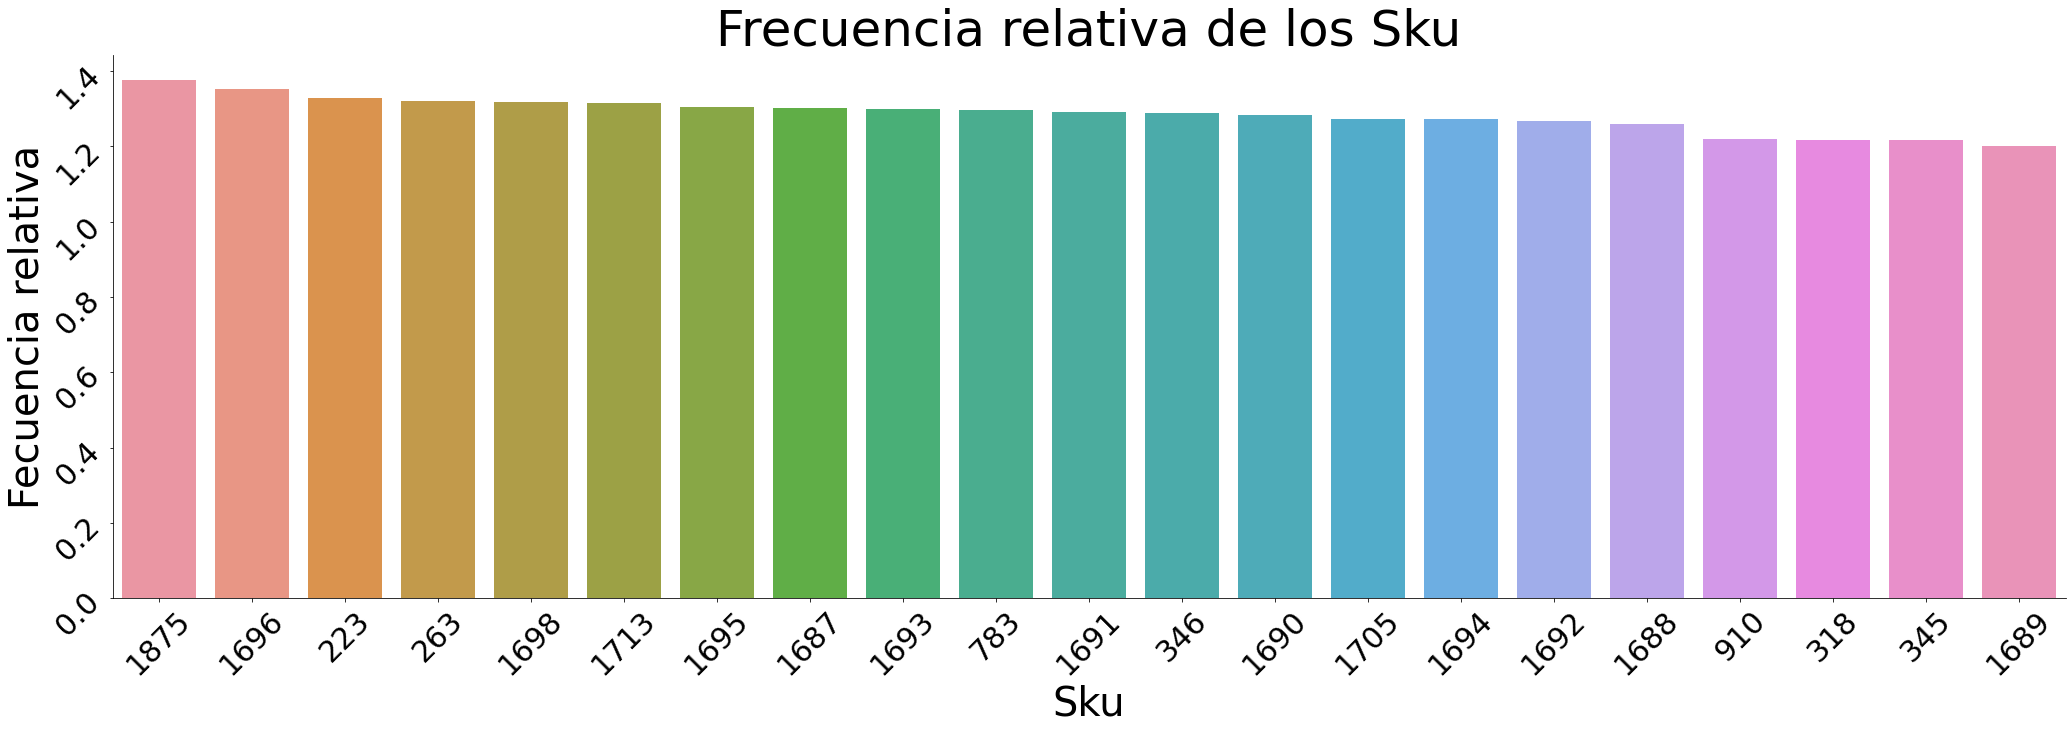

In [136]:
fig=plt.figure(figsize=(35,10),constrained_layout=False)
b=sns.barplot(x="sku",
           y="frec_relativa",
           data=frec_sku_filt)
b.tick_params(labelsize=25, rotation=45)
plt.title("Frecuencia relativa de los Sku", fontsize=50)
plt.xlabel("Sku",fontsize=40)
plt.ylabel("Fecuencia relativa",fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
sns.despine()


### Frecuencia de punto de ventas

In [137]:
id_punto_venta_count = df_finalarg.id_punto_venta.value_counts(ascending=False)\
    .reset_index()\
    .rename(columns={'index': "id_punto_venta","id_punto_venta": 'frecuencia_punto_venta'})
id_punto_venta_count['frec_relativa']= (id_punto_venta_count['frecuencia_punto_venta']/len(df_finalarg.id_punto_venta))*100
id_punto_venta_count.head()

id_punto_venta  frecuencia_punto_venta  frec_relativa
0         100147                   11839       0.275118
1         100697                   11067       0.257178
2         100914                   10505       0.244118
3         100375                   10322       0.239865
4       100697-1                    9913       0.230361

In [138]:
frec_idventa_filt=id_punto_venta_count[id_punto_venta_count['frec_relativa']>0.17]

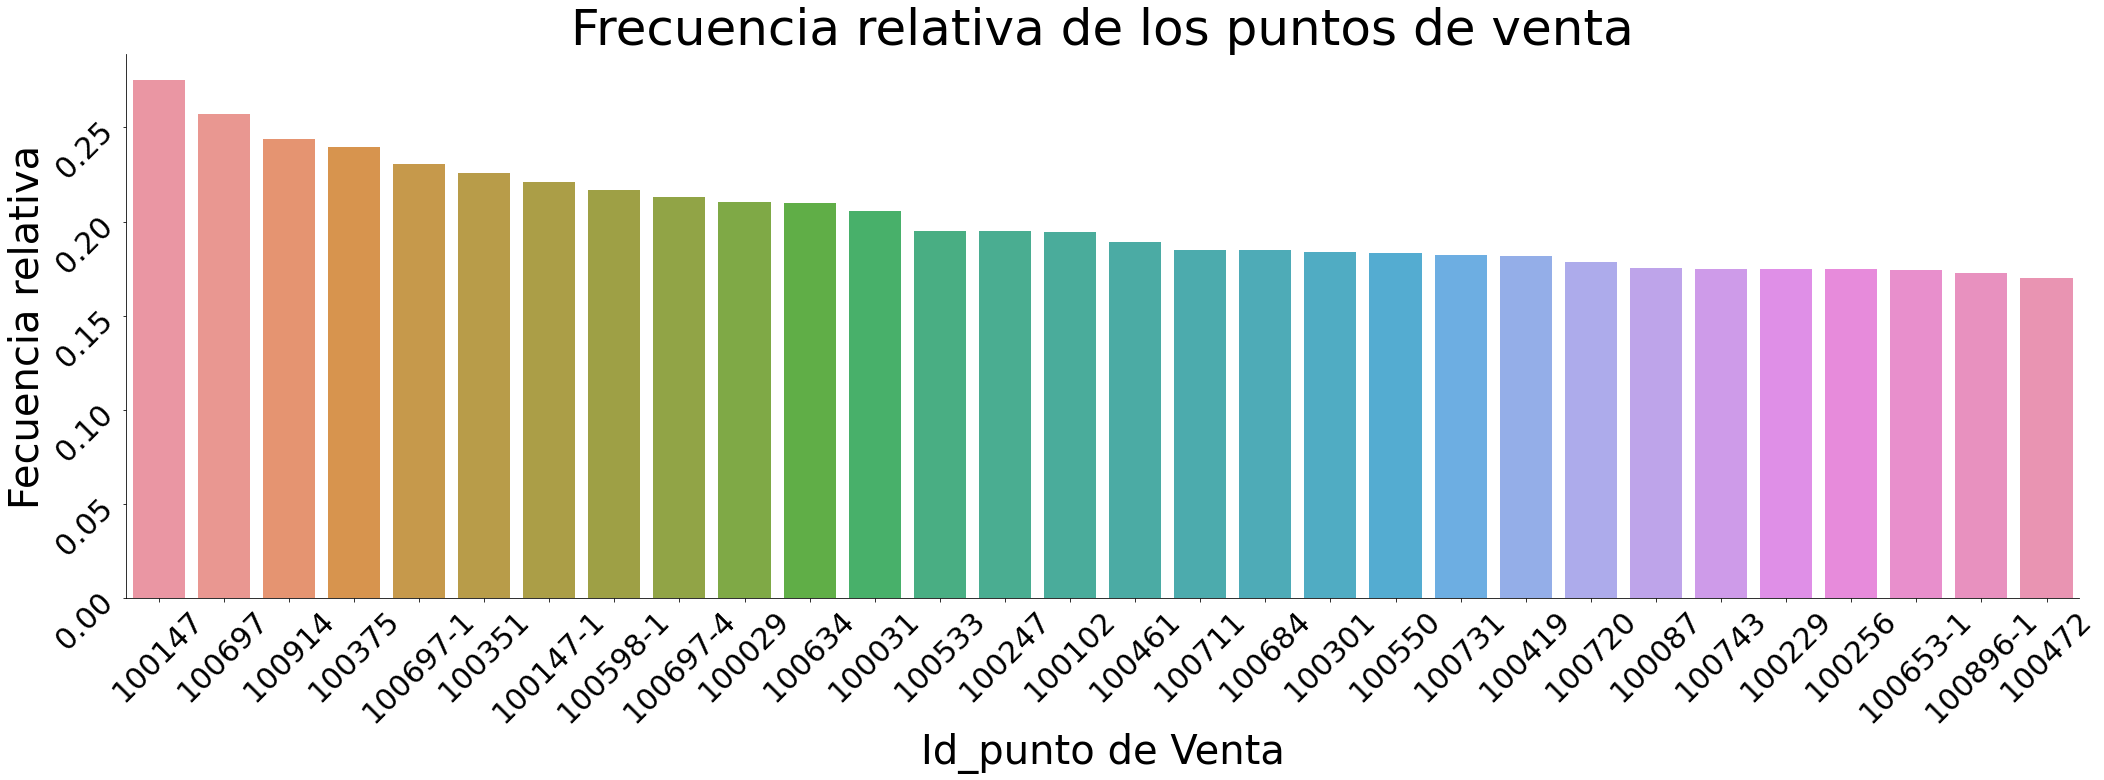

In [139]:
fig=plt.figure(figsize=(35,10),constrained_layout=False)
c=sns.barplot(x="id_punto_venta",
           y="frec_relativa",
           data=frec_idventa_filt)
c.tick_params(labelsize=20, rotation=45)

plt.title("Frecuencia relativa de los puntos de venta", fontsize=50)
plt.xlabel("Id_punto de Venta",fontsize=40)
plt.ylabel("Fecuencia relativa",fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

sns.despine()

### Frecuencia de loc_prov

In [140]:
locprov_count = df_finalarg.locprov.value_counts(ascending=False)\
    .reset_index()\
    .rename(columns={'index': "locprov","locprov": 'frecuencia_locprov'})
locprov_count['frec_relativa']= (locprov_count['frecuencia_locprov']/len(df_finalarg.locprov))*100
locprov_count.head()

locprov  frecuencia_locprov  \
0                                 CórdobaCórdoba              642952   
1                                Santa FeRosario               97901   
2                               Santa FeSanta Fé               85004   
3  Buenos AiresGeneral Pueyrredón, Mar Del Plata               76598   
4                                     SaltaSalta               73574   

   frec_relativa  
0      14.941079  
1       2.275048  
2       1.975344  
3       1.780003  
4       1.709731

In [141]:
frec_locprov_filt=locprov_count[locprov_count['frec_relativa']>0.5]
frec_locprov_filt.head()

locprov  frecuencia_locprov  \
0                                 CórdobaCórdoba              642952   
1                                Santa FeRosario               97901   
2                               Santa FeSanta Fé               85004   
3  Buenos AiresGeneral Pueyrredón, Mar Del Plata               76598   
4                                     SaltaSalta               73574   

   frec_relativa  
0      14.941079  
1       2.275048  
2       1.975344  
3       1.780003  
4       1.709731

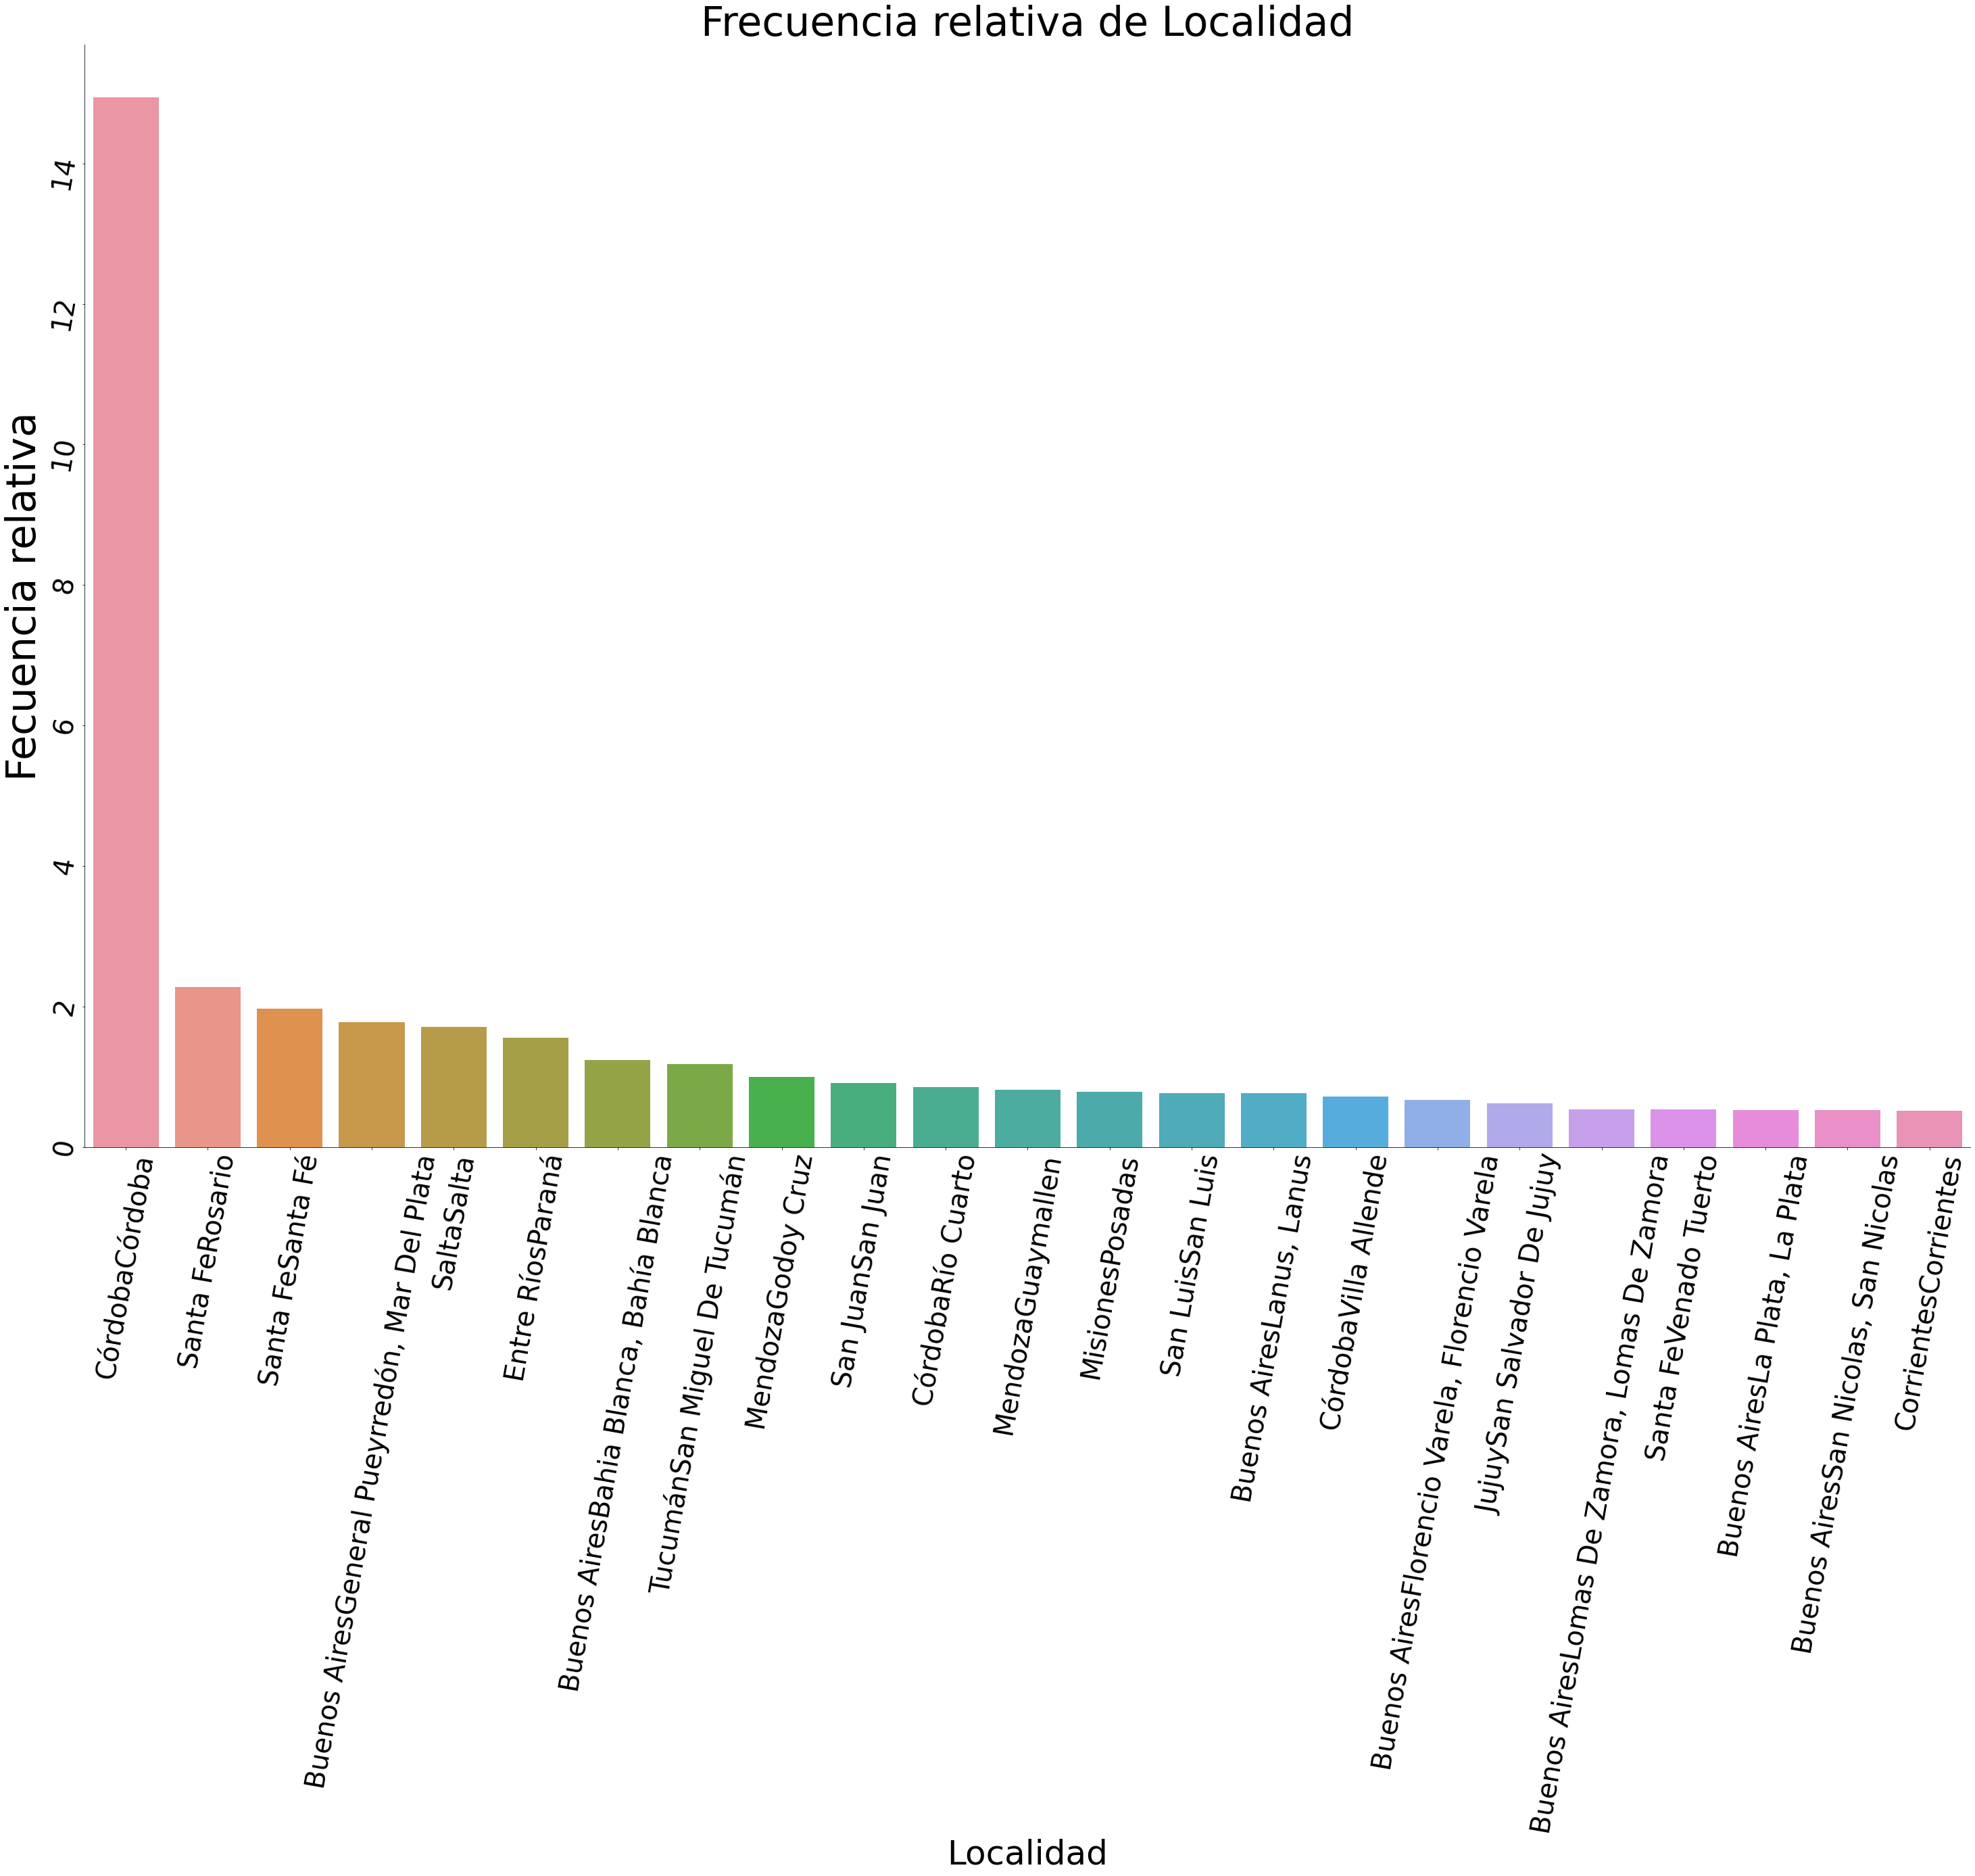

In [142]:
fig=plt.figure(figsize=(50,30))
d=sns.barplot(x="locprov",
           y="frec_relativa",
           data=frec_locprov_filt)
d.tick_params(labelsize=20, rotation=80)
d.set_xlabel("Localidad",fontsize=50)
plt.title("Frecuencia relativa de Localidad", fontsize=60)
plt.xlabel("Localidad",fontsize=50)
plt.ylabel("Fecuencia relativa",fontsize=60)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
sns.despine()

sns.despine()



# 18- Como es la distribución de totalkg condicionada a algunas otras variables que decida seleccionar?.

Text(0.5, 1.0, 'Distribución anual de las categorias mas solicitadas')

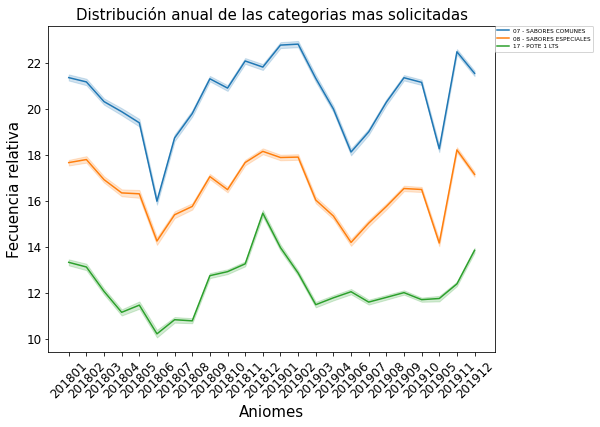

In [143]:
filt_3catppales= df_finalarg[(df_finalarg["categoria"]=="07 - SABORES COMUNES")| (df_finalarg['categoria']=="17 - POTE 1 LTS") | (df_finalarg['categoria']=="08 - SABORES ESPECIALES")]

plt.figure(figsize=(8,6))
sns.lineplot(y=filt_3catppales['totalkg'],x=filt_3catppales['aniomes'], hue=filt_3catppales['categoria'])
plt.xticks(rotation=45, fontsize=12)
plt.xlabel("Aniomes",fontsize=15)
plt.ylabel("Fecuencia relativa",fontsize=15)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0,fontsize='xx-small')
plt.title("Distribución anual de las categorias mas solicitadas",fontsize=15)

# 19- Indicar cuales son las variables que tienen mayor correlación

In [144]:
variables_interes=df_finalarg[['totalkg','cantidad_pedida','unidadcm3',	'unidadkg']]
corr= variables_interes.corr()
corr

totalkg  cantidad_pedida  unidadcm3  unidadkg
totalkg          1.000000         0.745981   0.020411  0.308409
cantidad_pedida  0.745981         1.000000  -0.097130 -0.223960
unidadcm3        0.020411        -0.097130   1.000000  0.234847
unidadkg         0.308409        -0.223960   0.234847  1.000000

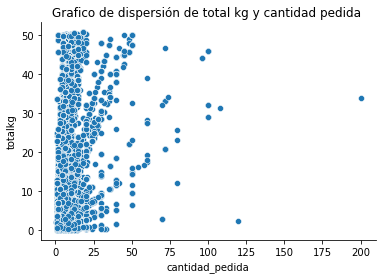

In [145]:
sns.scatterplot(data=df_finalarg, x="cantidad_pedida", y="totalkg")
plt.title('Grafico de dispersión de total kg y cantidad pedida ', fontsize=12)
sns.despine()
plt.show()

<AxesSubplot:>

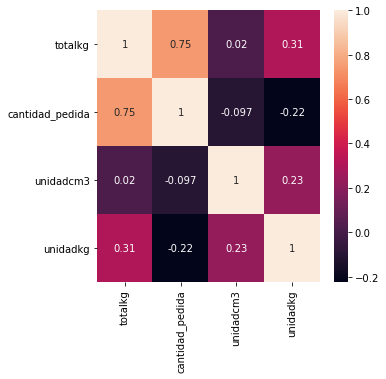

In [146]:
plt.figure(figsize=(5,5))
sns.heatmap(corr, annot = True)

# 20- Son estadísticamente distintas las medias o mediana (lo que indique que corresponde) de totalkg entre dos provincias (compare las dos provincias que mayor promedio de totalkg anual tienen)?

In [147]:
mediana_prov_2018=reg18.groupby(['Provincia'])['totalkg'].median().sort_values(ascending=False)
mediana_prov_2018[:2]

Provincia
Neuquén       23.4
Santa Cruz    22.8
Name: totalkg, dtype: float64

In [148]:
Neuq=reg18[reg18["Provincia"]=="Neuquén"]["totalkg"]
StaC=reg18[reg18["Provincia"]=="Santa Cruz"]["totalkg"]

In [149]:
import scipy.stats as st
st.ttest_ind(Neuq, StaC, axis=0, equal_var=False, nan_policy='propagate')
#print(alpha)

Ttest_indResult(statistic=-1.085493371233758, pvalue=0.27784513546898715)

    Para el año 2018 tomando las provincias que, en promedio solicitan mas cantidad de total Kg, podemos decir que si bien Neuquen vende más que Santa CRuz la diferencia no es estadísticamente significativa

In [150]:
mediana_prov_2019=reg19.groupby(['Provincia'])['totalkg'].median().sort_values(ascending=False)
mediana_prov_2019[:2]

Provincia
Santa Cruz    20.7
Chubut        20.7
Name: totalkg, dtype: float64

Para 2019, las medianas de totalkg  en Santa Cruz y Chubut son iguales (diferencia de medianas=0).

In [151]:
mediana_prov_2anios=df_finalarg.groupby(['Provincia'])['totalkg'].median().sort_values(ascending=False)
mediana_prov_2anios[:2]

Provincia
Chubut     21.04
Neuquén    21.04
Name: totalkg, dtype: float64

# 21- Son estadísticamente distintas las medias o mediana (lo que indique que corresponde) de totalkg entre los promedios de los 3 puntos de venta que mas venden y los 3 puntos de venta que menos venden?


In [152]:
##Para ambos años calculamos los kg totales del top 3 de puntos de venta
df_finalarg.groupby('Punto_Venta')['totalkg'].sum().sort_values(ascending=False)[:3]

Punto_Venta
SANXXX-XX-XXIII    603331.80552
SANXXX-XX-XX II    560941.71018
VILXXX-XX-XX II    556862.23913
Name: totalkg, dtype: float64

In [153]:
#Filtre el df con los puntos de venta top3
dfPto_Vta_top3=df_finalarg[(df_finalarg["Punto_Venta"]=="SANXXX-XX-XXIII")|\
                           (df_finalarg["Punto_Venta"]=="SANXXX-XX-XX II")|\
                           (df_finalarg["Punto_Venta"]=="VILXXX-XX-XX II")]


In [154]:
##Para ambos años calculamos los kg totales del bottom 3 de puntos de venta

df_finalarg.groupby('Punto_Venta')['totalkg'].sum().sort_values(ascending=True)[:3]

Punto_Venta
TUCXXX-XX-XXVII    0.66
MARXXX-XX-XXNAL    1.20
VILXXX-XX-XXNAL    1.45
Name: totalkg, dtype: float64

In [155]:
#Filtre el df con los puntos de venta bottom 3
dfPto_Vta_bottom3=df_finalarg[(df_finalarg["Punto_Venta"]=="TUCXXX-XX-XXVII")|\
                           (df_finalarg["Punto_Venta"]=="MARXXX-XX-XXNAL")|\
                           (df_finalarg["Punto_Venta"]=="VILXXX-XX-XXNAL")]

In [156]:
top3_PtoVta=dfPto_Vta_top3['totalkg'].median()
print(top3_PtoVta)
bottom3_PtoVta=dfPto_Vta_bottom3['totalkg'].median()
print(bottom3_PtoVta)

12.96
0.765


Para Los datos sin agrupar por año, la mediana de totalkg del top 3 de puntos de venta es igual a la del bottom 3

In [157]:
## VEAMOS PARA EL "2018" el top 3 de puntos de venta
reg18.groupby('Punto_Venta')['totalkg'].sum().sort_values(ascending=False)[:3]

Punto_Venta
SANXXX-XX-XXIII    292834.777
VILXXX-XX-XX II    286616.495
SANXXX-XX-XX II    276560.562
Name: totalkg, dtype: float64

In [158]:
#Filtre el df con los puntos de venta top3 de 2018
dfPto_Vta_top3_18=reg18[(reg18["Punto_Venta"]=="SANXXX-XX-XXIII")|\
                           (reg18["Punto_Venta"]=="VILXXX-XX-XX II")|\
                           (reg18["Punto_Venta"]=="SANXXX-XX-XX II")]

In [159]:
## VEAMOS PARA EL "2018" el bottom 3 de puntos de venta
reg18.groupby('Punto_Venta')['totalkg'].sum().sort_values(ascending=True)[:3]

Punto_Venta
VILXXX-XX-XXVII    1.2
MARXXX-XX-XXNAL    1.2
CORXXX-XX-XXOBA    1.5
Name: totalkg, dtype: float64

In [160]:
#Filtre el df con los puntos de venta bottom3 de 2018
dfPto_Vta_bottom3_18=reg18[(reg18["Punto_Venta"]=="VILXXX-XX-XXVII")|\
                           (reg18["Punto_Venta"]=="MARXXX-XX-XXNAL")|\
                           (reg18["Punto_Venta"]=="CORXXX-XX-XXOBA")]

In [161]:
top3_PtoVta18=dfPto_Vta_top3_18['totalkg'].median()
print(top3_PtoVta18)
bottom3_PtoVta18=dfPto_Vta_bottom3_18['totalkg'].median()
print(bottom3_PtoVta18)

15.6
1.2


In [162]:
Top3_Pvta_18=dfPto_Vta_top3_18.loc[:,"totalkg"]
len(Top3_Pvta_18)
Bottom3_Pvta_18=dfPto_Vta_bottom3_18.loc[:,"totalkg"]
len(Bottom3_Pvta_18)
st.ttest_ind(Top3_Pvta_18,Bottom3_Pvta_18, axis=0, equal_var=False, nan_policy='propagate')

Ttest_indResult(statistic=67.52618864662496, pvalue=2.5295819090420423e-06)

en 2018 Encontramos diferencias significativas entre las medianas de los puntos de venta aunque hay que tener en cuenta que los n de ambos grupos son muy diferentes(51000 vs 4)

In [163]:
## VEAMOS PARA EL "2018" el top 3 de puntos de venta
reg19.groupby('Punto_Venta')['totalkg'].sum().sort_values(ascending=False)[:3]

Punto_Venta
SANXXX-XX-XXIII    310497.02852
SANXXX-XX-XX II    284381.14818
VILXXX-XX-XX II    270245.74413
Name: totalkg, dtype: float64

In [164]:
#Filtre el df con los puntos de venta top3 de 2019
dfPto_Vta_top3_19=reg19[(reg19["Punto_Venta"]=="SANXXX-XX-XXIII")|\
                           (reg19["Punto_Venta"]=="VILXXX-XX-XX II")|\
                           (reg19["Punto_Venta"]=="SANXXX-XX-XX II")]


In [165]:
## VEAMOS PARA EL "2018" el bottom 3 de puntos de venta
reg19.groupby('Punto_Venta')['totalkg'].sum().sort_values(ascending=True)[:3]


Punto_Venta
TUCXXX-XX-XXVII    0.66
VILXXX-XX-XXNAL    1.45
VILXXX-XX-XX VI    2.39
Name: totalkg, dtype: float64

In [166]:
## VEAMOS PARA EL "2018" el bottom 3 de puntos de venta
reg19.groupby('Punto_Venta')['totalkg'].sum().sort_values(ascending=True)[:3]

#Filtre el df con los puntos de venta bottom3 de 2018
dfPto_Vta_bottom3_19=reg19[(reg19["Punto_Venta"]=="TUCXXX-XX-XXVII")|\
                           (reg19["Punto_Venta"]=="VILXXX-XX-XXNAL")|\
                           (reg19["Punto_Venta"]=="VILXXX-XX-XX VI")]

top3_PtoVta19=dfPto_Vta_top3_19['totalkg'].median()
print(top3_PtoVta19)
bottom3_PtoVta19=dfPto_Vta_bottom3_19['totalkg'].median()
print(bottom3_PtoVta19)

12.419999999999998
0.615


In [167]:
Top3_Pvta_19=dfPto_Vta_top3_19.loc[:,"totalkg"]
#len(Top3_Pvta_19)
Bottom3_Pvta_19=dfPto_Vta_bottom3_19.loc[:,"totalkg"]
#len(Bottom3_Pvta_19)
st.ttest_ind(Top3_Pvta_19,Bottom3_Pvta_19, axis=0, equal_var=False, nan_policy='propagate')

Ttest_indResult(statistic=57.23765585134456, pvalue=1.0733522247057088e-08)

en 2019 Encontramos diferencias significativas entre las medianas de los puntos de venta aunque hay que tener en cuenta que los n de ambos grupos son muy diferentes(56694 vs 6)

# 22- Establecer la probabilidad de que el promedio de los pedidos realizados por los puntos de venta pertenecientes a Córdoba se encuentren por encima de la media nacional? Realice este análisis tomando los promedios mensuales.


In [172]:
# Media de 'totalkg' por mes a nivel nacional
arg_mes_prom=df_finalarg.groupby(["MES"])["totalkg"].mean().round()

In [173]:
# Media de 'totalkg' por mes correspondiente a Córdoba
cba_filt=df_finalarg[df_finalarg['Provincia']=='Córdoba']
cba_mes_prom=cba_filt.groupby(["MES"])["totalkg"].mean().round()

In [174]:
aux=df_finalarg.groupby(by=['aniomes'], as_index=False)['totalkg'].mean().rename(columns={'totalkg':'promedionacional'}) \
.merge(df_finalarg[df_finalarg['Provincia']=='Córdoba'].groupby(by=['aniomes'], as_index=False)['totalkg'].mean() \
.rename(columns={'totalkg':'promediocordoba'}), how='inner', on='aniomes')
# Creamos una nueva columna
aux=aux.assign(diferencia=aux.promediocordoba-aux.promedionacional)
print('Probabilidad de que los puntos de ventas de Cordoba pidan en promedio mas que el' 
      'promedio nacional a nivel mensual es {0}%'
        .format(len(aux[aux['diferencia']>0])/len(aux)))
aux.head()

Probabilidad de que los puntos de ventas de Cordoba pidan en promedio mas que elpromedio nacional a nivel mensual es 0.0%


aniomes  promedionacional  promediocordoba  diferencia
0  201801         16.604616        13.903775   -2.700841
1  201802         16.557011        13.633182   -2.923829
2  201803         16.025460        13.262975   -2.762485
3  201804         15.520370        13.264454   -2.255916
4  201805         15.440609        12.604984   -2.835625

In [175]:
aux2=df_finalarg.groupby(by=['aniomes'], as_index=False)['totalkg'].mean().rename(columns={'totalkg':'promedionacional'}) \
.merge(df_finalarg[df_finalarg['Provincia']=='Buenos Aires'].groupby(by=['aniomes'], as_index=False)['totalkg'] \
.mean().rename(columns={'totalkg':'promediobuenosaires'}), how='inner', on='aniomes')
# Creamos una nueva columna
aux2=aux2.assign(diferencia=aux2.promediobuenosaires-aux2.promedionacional)
print("Probabilidad de que los puntos de ventas de Buenos Aires pidan en promedio mas que el" 
      "promedio nacional a nivel mensual es {0}%"
      .format(len(aux2[aux2['diferencia']>0])/len(aux2)))
aux2.head()

Probabilidad de que los puntos de ventas de Buenos Aires pidan en promedio mas que elpromedio nacional a nivel mensual es 1.0%


aniomes  promedionacional  promediobuenosaires  diferencia
0  201801         16.604616            18.388718    1.784102
1  201802         16.557011            18.120433    1.563422
2  201803         16.025460            17.015632    0.990172
3  201804         15.520370            16.395817    0.875447
4  201805         15.440609            16.324734    0.884126

In [176]:
aux3=df_finalarg.groupby(by=['aniomes'], as_index=False)['totalkg'].mean().rename(columns={'totalkg':'promedionacional'}) \
.merge(df_finalarg[df_finalarg['Provincia']=='Tierra del Fuego'].groupby(by=['aniomes'], as_index=False)['totalkg'] \
.mean().rename(columns={'totalkg':'promediotierradelfuego'}), how='inner', on='aniomes')
# Creamos una nueva columna
aux3=aux3.assign(diferencia=aux3.promediotierradelfuego-aux3.promedionacional)
print("Probabilidad de que los puntos de ventas de Tierra del fuego pidan en " 
      "promedio mas que el promedio nacional a nivel mensual es {0}%"
      .format(len(aux3[aux3['diferencia']>0])/len(aux3)))
aux3.head()

Probabilidad de que los puntos de ventas de Tierra del fuego pidan en promedio mas que el promedio nacional a nivel mensual es 0.3333333333333333%


aniomes  promedionacional  promediotierradelfuego  diferencia
0  201801         16.604616               15.140492   -1.464124
1  201802         16.557011               18.069250    1.512239
2  201803         16.025460               15.633143   -0.392317
3  201804         15.520370               18.044138    2.523768
4  201805         15.440609               17.311780    1.871171

In [177]:
aux4=df_finalarg.groupby(by=['aniomes'], as_index=False)['totalkg'].mean().rename(columns={'totalkg':'promedionacional'}) \
.merge(df_finalarg[df_finalarg['Provincia']=='Santa Fe'].groupby(by=['aniomes'], as_index=False)['totalkg'] \
.mean().rename(columns={'totalkg':'promediosantafe'}), how='inner', on='aniomes')
# Creamos una nueva columna
aux4=aux4.assign(diferencia=aux4.promediosantafe-aux4.promedionacional)
print("Probabilidad de que los puntos de ventas de Santa Fe pidan en" 
      "promedio mas que el promedio nacional a nivel mensual es {0}%"
      .format(len(aux4[aux4['diferencia']>0])/len(aux4)))
aux4.head()

Probabilidad de que los puntos de ventas de Santa Fe pidan enpromedio mas que el promedio nacional a nivel mensual es 0.08333333333333333%


aniomes  promedionacional  promediosantafe  diferencia
0  201801         16.604616        16.670894    0.066278
1  201802         16.557011        16.487750   -0.069261
2  201803         16.025460        15.794185   -0.231275
3  201804         15.520370        15.403514   -0.116856
4  201805         15.440609        15.232321   -0.208287

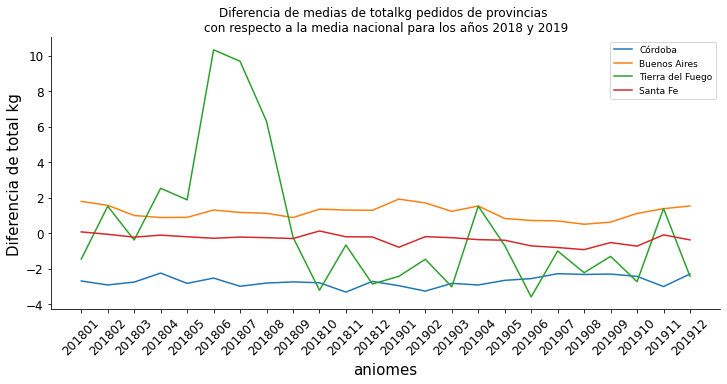

In [178]:
plt.figure(figsize= (12,5))
sns.lineplot(x='aniomes', y='diferencia', data=aux, label='Córdoba')
sns.lineplot(x='aniomes', y='diferencia', data=aux2, label='Buenos Aires')
sns.lineplot(x='aniomes', y='diferencia', data=aux3, label='Tierra del Fuego')
sns.lineplot(x='aniomes', y='diferencia', data=aux4, label='Santa Fe')
plt.legend(loc='best', fontsize=9)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Diferencia de medias de totalkg pedidos de provincias \ncon respecto a la media nacional para los años 2018 y 2019', fontsize=12)
plt.ylabel('Diferencia de total kg', fontsize=15)
plt.xlabel('aniomes', fontsize=15)
sns.despine()
plt.show()

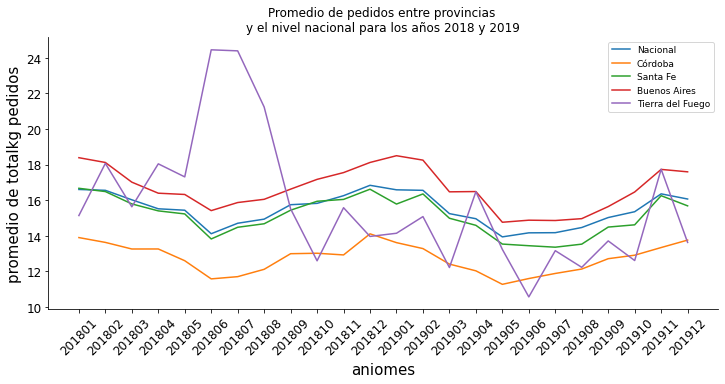

In [179]:
plt.figure(figsize= (12,5))
sns.lineplot(x='aniomes', y='promedionacional', data=aux, label='Nacional')
sns.lineplot(x='aniomes', y='promediocordoba', data=aux, label='Córdoba')
sns.lineplot(x='aniomes', y='promediosantafe', data=aux4, label='Santa Fe')
sns.lineplot(x='aniomes', y='promediobuenosaires', data=aux2, label='Buenos Aires')
sns.lineplot(x='aniomes', y='promediotierradelfuego', data=aux3, label='Tierra del Fuego')
plt.legend(loc='best', fontsize=9)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Promedio de pedidos entre provincias \ny el nivel nacional para los años 2018 y 2019', fontsize=12)
plt.ylabel('promedio de totalkg pedidos', fontsize=15)
plt.xlabel('aniomes', fontsize=15)
sns.despine()
plt.show()


# 23- En que época del año el promedio de totalkg por provincia y categoria (tome solo las 3 categorias mas pedidas) es mas alto y en cual es mas bajo?. Que comportamiento se observa en los pedidos?

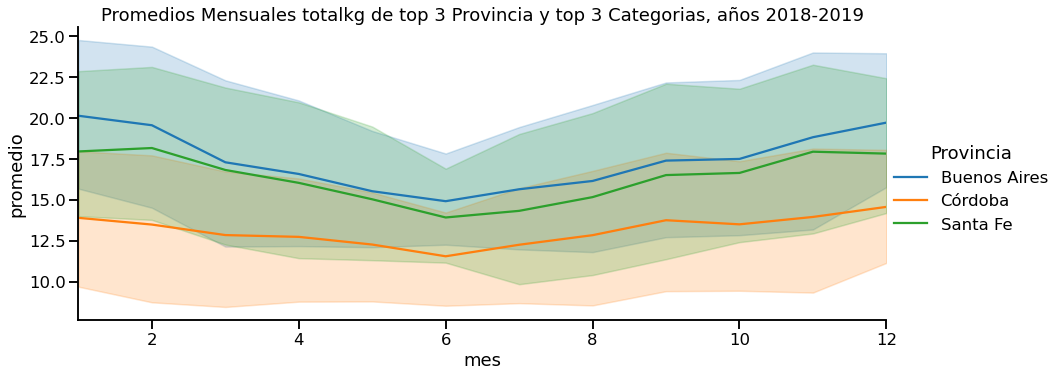

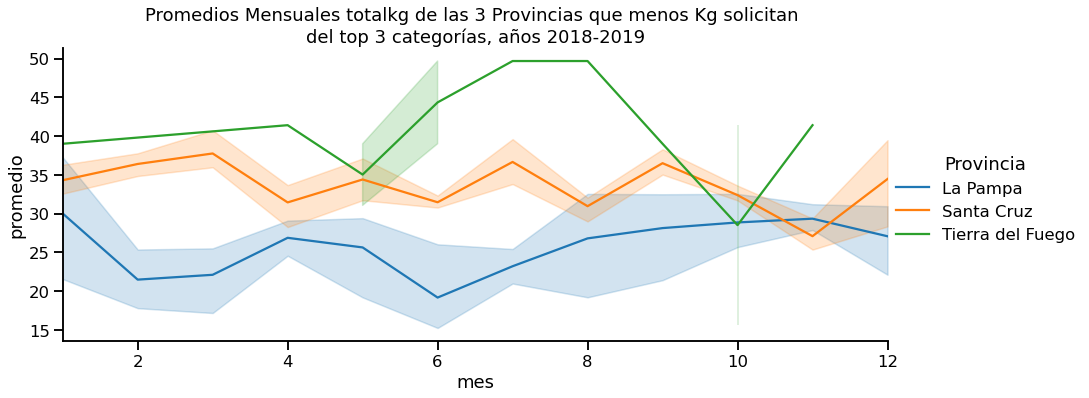

In [180]:
####AÑO "2018-2019"
# Obtenemos el top 3 de las categorias mas vendidas
top_cat=df_finalarg.groupby(by=['categoria'], as_index=False)['totalkg'].sum().sort_values(["totalkg"], ascending = False) \
.reset_index(drop=True).head(3)
# Obtenemos el top 3 de las provincias que mas venden
top_prov=df_finalarg.groupby(by=['Provincia'], as_index=False)['totalkg'].sum().sort_values(["totalkg"], ascending = False) \
.reset_index(drop=True).head(3)

aux5=df_finalarg[df_finalarg.categoria.isin(top_cat.categoria) & df_finalarg.Provincia.isin(top_prov.Provincia)] \
.groupby(by=['mes','Provincia','categoria'], as_index=False)['totalkg'].mean().rename(columns={'totalkg':'promedio'})
sns.set_context('talk')
sns.relplot(data=aux5, x="mes", y="promedio", hue='Provincia', kind="line", aspect=2.5)
sns.despine()
plt.xlim(1,12)
plt.title("Promedios Mensuales totalkg de top 3 Provincia y top 3 Categorias, años 2018-2019")


#3 categorias mas vendidas en las 3 provincias que menos venden. 
#Obtenemos las 3 categorias menos vendidas
top_cat=df_finalarg.groupby(by=['categoria'], as_index=False)['totalkg'].sum().sort_values(["totalkg"], ascending = False) \
.reset_index(drop=True).head(3)
# Obtenemos las 3 provincias que menos kg venden
bottom_prov=df_finalarg.groupby(by=['Provincia'], as_index=False)['totalkg'].sum().sort_values(["totalkg"], ascending = True) \
.reset_index(drop=True).head(3)

aux6=df_finalarg[df_finalarg.categoria.isin(top_cat.categoria) & df_finalarg.Provincia.isin(bottom_prov.Provincia)] \
.groupby(by=['mes','Provincia','categoria'], as_index=False)['totalkg'].mean().rename(columns={'totalkg':'promedio'})
sns.set_context('talk')
sns.relplot(data=aux6, x="mes", y="promedio", hue='Provincia', kind="line", aspect=2.5)
sns.despine()
plt.xlim(1,12)
plt.title("Promedios Mensuales totalkg de las 3 Provincias que menos Kg solicitan \ndel top 3 categorías, años 2018-2019")

plt.show()

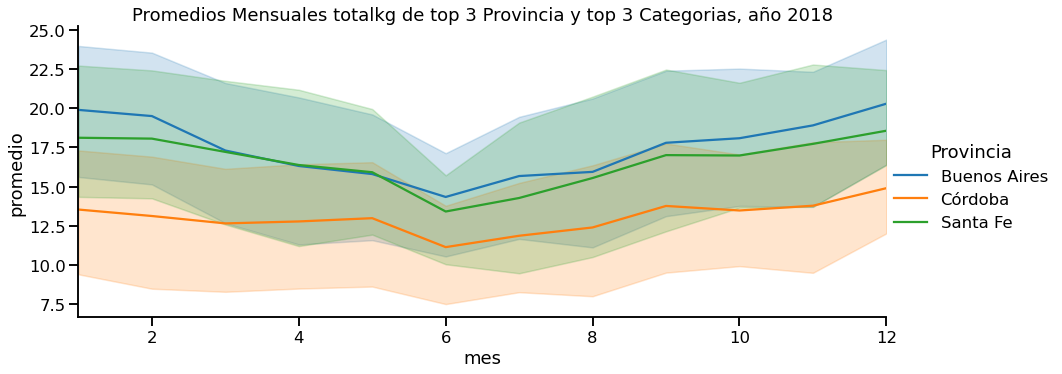

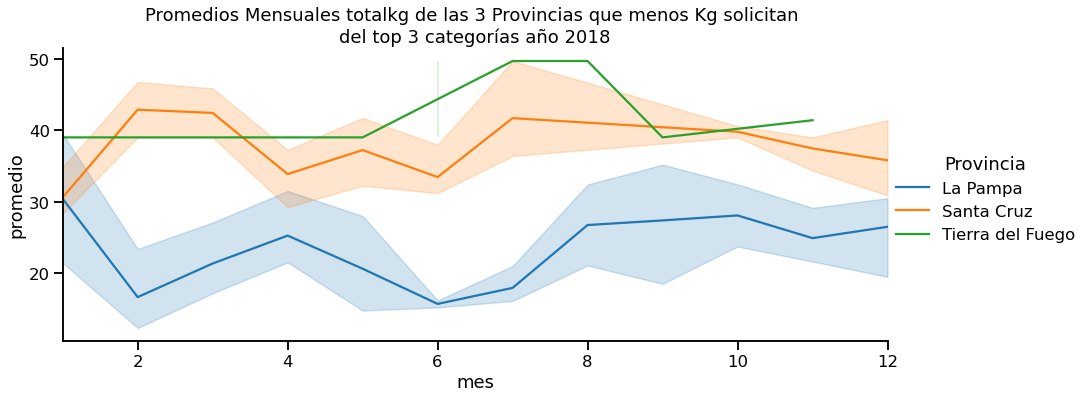

In [181]:
####AÑO "2018"
# Obtenemos el top 3 de las categorias mas vendidas
top_cat=reg18.groupby(by=['categoria'], as_index=False)['totalkg'].sum().sort_values(["totalkg"], ascending = False) \
.reset_index(drop=True).head(3)
# Obtenemos el top 3 de las provincias que mas venden
top_prov=reg18.groupby(by=['Provincia'], as_index=False)['totalkg'].sum().sort_values(["totalkg"], ascending = False) \
.reset_index(drop=True).head(3)

aux5=reg18[reg18.categoria.isin(top_cat.categoria) & reg18.Provincia.isin(top_prov.Provincia)] \
.groupby(by=['mes','Provincia','categoria'], as_index=False)['totalkg'].mean().rename(columns={'totalkg':'promedio'})
sns.set_context('talk')
sns.relplot(data=aux5, x="mes", y="promedio", hue='Provincia', kind="line", aspect=2.5)
sns.despine()
plt.xlim(1,12)
plt.title("Promedios Mensuales totalkg de top 3 Provincia y top 3 Categorias, año 2018")


#3 categorias mas vendidas en las 3 provincias que menos venden. 
#Obtenemos las 3 categorias menos vendidas
top_cat=reg18.groupby(by=['categoria'], as_index=False)['totalkg'].sum().sort_values(["totalkg"], ascending = False) \
.reset_index(drop=True).head(3)
# Obtenemos las 3 provincias que menos kg venden
bottom_prov=reg18.groupby(by=['Provincia'], as_index=False)['totalkg'].sum().sort_values(["totalkg"], ascending = True) \
.reset_index(drop=True).head(3)

aux6=reg18[reg18.categoria.isin(top_cat.categoria) & reg18.Provincia.isin(bottom_prov.Provincia)] \
.groupby(by=['mes','Provincia','categoria'], as_index=False)['totalkg'].mean().rename(columns={'totalkg':'promedio'})
sns.set_context('talk')
sns.relplot(data=aux6, x="mes", y="promedio", hue='Provincia', kind="line", aspect=2.5)
sns.despine()
plt.xlim(1,12)
plt.title("Promedios Mensuales totalkg de las 3 Provincias que menos Kg solicitan \ndel top 3 categorías año 2018")

plt.show()

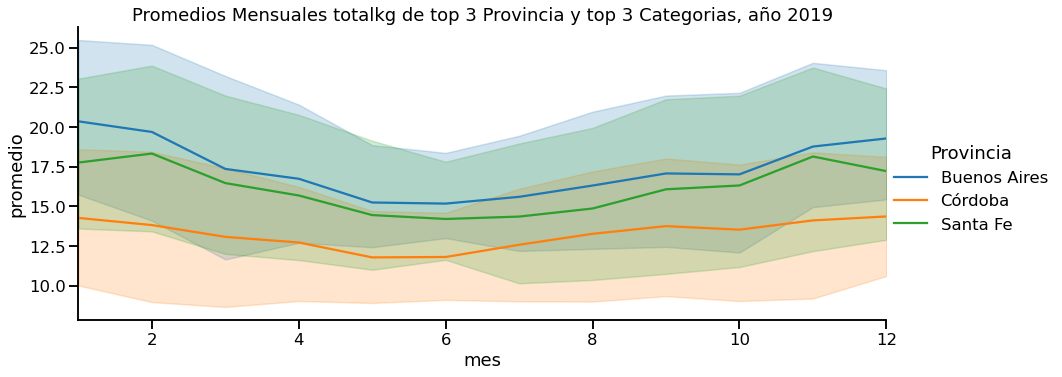

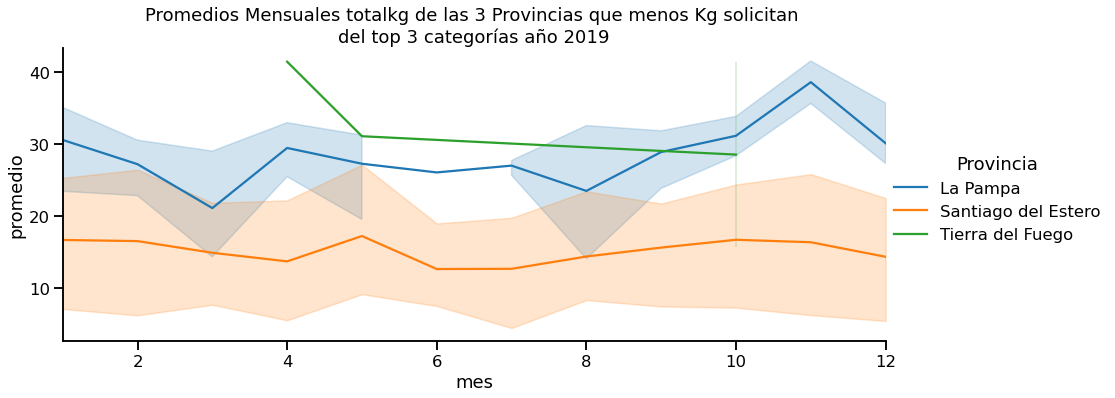

In [182]:
####AÑO "2019"
# Obtenemos el top 3 de las categorias mas vendidas
top_cat=reg19.groupby(by=['categoria'], as_index=False)['totalkg'].sum().sort_values(["totalkg"], ascending = False) \
.reset_index(drop=True).head(3)
# Obtenemos el top 3 de las provincias que mas venden
top_prov=reg19.groupby(by=['Provincia'], as_index=False)['totalkg'].sum().sort_values(["totalkg"], ascending = False) \
.reset_index(drop=True).head(3)

aux5=reg19[reg19.categoria.isin(top_cat.categoria) & reg19.Provincia.isin(top_prov.Provincia)] \
.groupby(by=['mes','Provincia','categoria'], as_index=False)['totalkg'].mean().rename(columns={'totalkg':'promedio'})
sns.set_context('talk')
sns.relplot(data=aux5, x="mes", y="promedio", hue='Provincia', kind="line", aspect=2.5)
sns.despine()
plt.xlim(1,12)
plt.title("Promedios Mensuales totalkg de top 3 Provincia y top 3 Categorias, año 2019")


#3 categorias mas vendidas en las 3 provincias que menos venden. 
#Obtenemos las 3 categorias menos vendidas
top_cat=reg19.groupby(by=['categoria'], as_index=False)['totalkg'].sum().sort_values(["totalkg"], ascending = False) \
.reset_index(drop=True).head(3)
# Obtenemos las 3 provincias que menos kg venden
bottom_prov=reg19.groupby(by=['Provincia'], as_index=False)['totalkg'].sum().sort_values(["totalkg"], ascending = True) \
.reset_index(drop=True).head(3)

aux6=reg19[reg19.categoria.isin(top_cat.categoria) & reg19.Provincia.isin(bottom_prov.Provincia)] \
.groupby(by=['mes','Provincia','categoria'], as_index=False)['totalkg'].mean().rename(columns={'totalkg':'promedio'})
sns.set_context('talk')
sns.relplot(data=aux6, x="mes", y="promedio", hue='Provincia', kind="line", aspect=2.5)
sns.despine()
plt.xlim(1,12)
plt.title("Promedios Mensuales totalkg de las 3 Provincias que menos Kg solicitan \ndel top 3 categorías año 2019")

plt.show()

In [183]:
#Exploramos la cantidad de puntos de venta de las ppales provincias y tb para Tierra del fuego

filtroBaires=df_finalarg[df_finalarg["Provincia"]=="Buenos Aires"]
filtroCBa=df_finalarg[df_finalarg["Provincia"]=="Córdoba"]
filtroSfe=df_finalarg[df_finalarg["Provincia"]=="Santa Fe"]
filtroSal=df_finalarg[df_finalarg["Provincia"]=="Salta"]
filtroTF=df_finalarg[df_finalarg["Provincia"]=="Tierra del Fuego"]

bai=len(filtroBaires.groupby("id_punto_venta")["id_punto_venta"].unique())
print(bai)
Cor=len(filtroCBa.groupby("id_punto_venta")["id_punto_venta"].unique())
print(Cor)
Sfe=len(filtroSfe.groupby("id_punto_venta")["id_punto_venta"].unique())
print(Sfe)
Sal=len(filtroSal.groupby("id_punto_venta")["id_punto_venta"].unique())
print(Sal)
TF=len(filtroTF.groupby("id_punto_venta")["id_punto_venta"].unique())
print(TF)

439
284
138
43
3
